# Employment

Plotting data for the US Labor Market

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# path for the folder "project"
path = "C:\\Users\\pedro\\OneDrive\\NYU\\CSS\\II. Data Skills\\project"
os.chdir(path)

# colors
colors = [
    '#1B4F72','#D35400','#16A05D','#DC2F1D','#3498DB','#9C9C9C','#F39C12','#28B463','#EC7063','#F1C40F',  # custom
    '#641E16','#7B241C','#922B21','#A93226','#C0392B','#CD6155','#D98880','#E6B0AA','#F2D7D5','#F9EBEA',  # dark red
    '#78281F','#943126','#B03A2E','#CB4335','#E74C3C','#EC7063','#F1948A','#F5B7B1','#FADBD8','#FDEDEC',  # red
    '#154360','#1A5276','#1F618D','#2471A3','#2980B9','#5499C7','#7FB3D5','#A9CCE3','#D4E6F1','#EAF2F8',  # dark blue
    '#1B4F72','#21618C','#2874A6','#2E86C1','#3498DB','#5DADE2','#85C1E9','#AED6F1','#D6EAF8','#EBF5FB',  # blue
    '#145A32','#196F3D','#1E8449','#229954','#27AE60','#52BE80','#7DCEA0','#A9DFBF','#D4EFDF','#E9F7EF',  # dark green
    '#0B5345','#0E6655','#117A65','#138D75','#16A085','#45B39D','#73C6B6','#A2D9CE','#D0ECE7','#E8F6F3',  # green
    '#6E2C00','#873600','#A04000','#BA4A00','#D35400','#DC7633','#E59866','#EDBB99','#F6DDCC','#FBEEE6',  # dark orange
    '#784212','#935116','#AF601A','#CA6F1E','#E67E22','#EB984E','#F0B27A','#F5CBA7','#FAE5D3','#FDF2E9',  # orange
    '#7D6608','#9A7D0A','#B7950B','#D4AC0D','#F1C40F','#F4D03F','#F7DC6F','#F9E79F','#FCF3CF','#FEF9E7',  # yellow
    '#626567','#797D7F','#909497','#A6ACAF','#BDC3C7','#CACFD2','#D7DBDD','#E5E7E9','#F2F3F4','#F8F9F9']  # gray


plt.style.use('seaborn-bright')
plt.rcParams['figure.dpi'] = 200 # high quality figure.
%matplotlib inline

## Functions

Writting functions to transform and plot data.  
For more details about the functions, take a look at the `charts_inflation` notebook.

In [2]:
# creating function to calculate percent changes.

def compute_change(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates yoy changes for different groups in the Data Frame.
    ---
    paramns:
        x: pandas dataframe with date, series_id and values columns.
        n: int representing the percent change period. (n=12 for YoY, n=1 for MoM)
        dt: dates column name
        series: series_id column name
        value: values column name
    
    returns: pandas data frame with yoy changes by group in the original value column.
    """
    return (x
            .sort_values(dt)
            .set_index([dt, series])
            .groupby(pd.Grouper(level = series))[value]
            .pct_change(periods = n)
            .dropna()
            .reset_index()
            .eval(f"{value} = {value}*100"))


In [3]:
# function to calculate monthly annual change rates.

def saar(x, n, dt = "date", series="series_id", value = "value"):
    """
    Calculates monthly annual rate changes
    ---
    paramns:
        x: pandas dataframe with date, series id and values columns
        n: [int] Number of months
        dt: [str] dates column name
        series: [str] series_id column name
        value: [str] values column name
    
    returns: pandas series with yoy changes by group.
    """
    x = (x
         .sort_values(dt)
         .set_index(dt)
         .groupby(series)[value]
         .rolling(n)
         .mean()
         .dropna()
         .reset_index())
    
    x = (x
         .sort_values(dt)
         .set_index([dt, series])
         .groupby(pd.Grouper(level = series))[value]
         .pct_change(periods = n)
         .dropna()
         .reset_index()
         .eval(f"{value} = {value}+1")
         .eval(f"{value} = ({value}**{12/n} -1) * 100"))
      
    return x


In [4]:
# function to plot time series data.

def ts_plot(df, df_map, start_date, title, ylab,
            fig_size = (12,6), legend_loc = "upper left",
            plot_recession = True, plot_zero = True,
            xmargin = 0.01, ymargin = 0.04,
            y_major_loc = 2, y_minor_loc = 2,
            x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # last observation
    last = df.groupby("series_id")["date"].max().reset_index()
    last = pd.merge(last,df,how="left", on=["series_id","date"])
    
    # line plot using seaborn and annotation
    for i in range(len(df_map)):
    
        sns.lineplot(
            data=df[df["series_id"]==df_map.loc[i][0]], #filter series
            x="date", y="value",
            color=df_map.loc[i][1], # map color
            alpha = df_map.loc[i][2], # map alpha
            ax=ax, legend=False)
    
        if df_map.loc[i][3] == True:
            ax.annotate(text = round(last.loc[last["series_id"] == df_map.loc[i][0], "value"].values[0],1),
                        xy = (last.loc[last["series_id"] == df_map.loc[i][0], "date"],
                              last.loc[last["series_id"] == df_map.loc[i][0], "value"]),
                        xycoords = "data", xytext = (1,0), textcoords="offset points",
                        color = df_map.loc[i][1], alpha = df_map.loc[i][2],
                        size='small', stretch="ultra-expanded",weight="semibold")
    
    # adding legend
    ax.legend(list(df_map["series_id"].values), 
        loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ylab, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax.spines['right'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date),pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = last["date"].dt.strftime("%B, %Y").max()
    ax.set_xlabel(f"last update: {sub}",labelpad = 8, loc="center")
    
    return fig, ax


In [5]:
# function to plot time series data with two y-axis.
def dual_ts_plot(df, series1, series2, start_date, title, ly_label, ry_label,
                 fig_size = (12,6), legend_loc = "upper left",
                 plot_recession = True, plot_zero = True,
                 xmargin = 0.01, ymargin = 0.04,
                 y_major_loc = 2, y_minor_loc = 2,
                 x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n = 0):
    """
    Time Series Plot that consumes a DataFrame in the long format, with
    columns series_id, date and value.
    ----
    Params:
        df: The long format pandas dataframe.
        df_map: data frame with series id, color code,
                alpha [0,1] and annotation (True or False).
        start_date: [srt] date the chart should start.
        title: [str] chart title.
        ylab: [str] y axis title.
        n: [int] additional space (in days) at the right side of the chart.
        Others:
             
        
    ----
    Returns:
        figure and axes objects.
    """
    
    # starting plot
    fig, ax = plt.subplots(figsize = fig_size)
    
    # filter date
    df = df[df["date"] >= start_date]
        
    # inside the function:
    data1 = df[df["series_id"]==series1].copy()
    data2 = df[df["series_id"]==series2].copy()
    
    mean1 = np.mean(data1["value"])
    sd1 = np.std(data1["value"])
    
    mean2 = np.mean(data2["value"])
    sd2 = np.std(data2["value"])
    
    data2["value"] = ((data2["value"] - mean2)/sd2)*sd1 + mean1
    
    # line plot using seaborn
    sns.lineplot(data=data1,
                 x="date", y="value",
                 color=colors[0], ax=ax, legend=False)
    
    sns.lineplot(data=data2,
                 x="date", y="value", color=colors[1], ax=ax, legend=False)
    
    ax2 = ax.twinx()
    
    y1, y2 = ax.get_ylim()
    ax2.set_ylim(sd2*((y1-mean1)/sd1)+mean2, sd2*((y2-mean1)/sd1)+mean2)
        
    # adding legend
    ax.legend([ly_label, ry_label],
              loc= legend_loc, frameon=True, framealpha=0.9, fontsize='small')
    
    # plotting recessions
    if plot_recession == True:
        
        recessions = pd.DataFrame({
                'start': ['1948-11-01', '1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01', '1973-11-01', '1980-01-01', 
                '1981-07-01', '1990-07-01', '2001-03-01', '2007-12-01', '2020-02-01'],
                'end': ['1949-10-01', '1954-05-01', '1958-04-01', '1961-02-01', '1970-11-01', '1975-03-01', '1980-07-01', 
                '1982-11-01', '1991-03-01', '2001-11-01', '2009-06-01', '2020-06-01']
            })
        
        recessions["start"] = pd.to_datetime(recessions["start"])
        recessions["end"] = pd.to_datetime(recessions["end"])
        
        recessions = recessions[recessions["start"]>=start_date]
        
        # plotting
        for i in range(recessions.shape[0]):
            ax.axvspan(recessions.iloc[i]["start"], recessions.iloc[i]["end"],
                       ec=None, color=colors[100], alpha=0.3)
    
    if plot_zero == True:
        
        # adding gray line at zero:
        ax.axhline(y=0, color='gray', lw=0.8)
    
    # 1% margin at date axis, and 4% in y axis:
    ax.margins(x=xmargin, y=ymargin)
    
    # y axis
    ax.set_ylabel(ly_label, size='medium')
    ax.yaxis.set_major_locator(MultipleLocator(y_major_loc))
    ax.yaxis.set_minor_locator(AutoMinorLocator(y_minor_loc))
    ax2.set_ylabel(ry_label, size='medium')
    
    # date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_major_loc))
    ax.xaxis.set_minor_locator(AutoMinorLocator(x_minor_loc))
    
    year_month_formatter = mdates.DateFormatter(x_format)
    ax.xaxis.set_major_formatter(year_month_formatter)
    
    # dropping top and right spines.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['top'].set_edgecolor(colors[107])
    ax2.spines['top'].set_edgecolor(colors[107])

    # grid lines
    ax.grid(axis='y', alpha=0.3)
    ax.grid(axis='x', alpha=0.3)
    
    # adjusting x axis limits
    ax.set_xlim([pd.to_datetime(start_date), pd.to_datetime(df["date"].max()) + pd.Timedelta(days=n)])
    
    # adding title
    ax.set_title(title, y=1.05, loc="center",
                fontweight="bold")
    
    # subtitle (Improvising here)
    # With a lot of data sources,
    # plotting the last observation date is a good way to check if everything is being updated.
    ax.xaxis.set_label_position('top')
    sub = df["date"].max().strftime("%B, %Y")
    ax.set_xlabel(f"last update: {sub}", labelpad = 8, loc="center")
    
    return fig, ax



## Importing Data

In [6]:
# BLS data:
ces = pd.read_parquet("data\\employment\\data_bls_ces.parquet")
cps = pd.read_parquet("data\\employment\\data_bls_cps.parquet")
jolts = pd.read_parquet("data\\employment\\data_bls_jolts.parquet")

# BLS dict:
ces_dict = pd.read_parquet("data\\employment\\dict_bls_ces.parquet")
cps_dict = pd.read_parquet("data\\employment\\dict_bls_cps.parquet")
jolts_dict = pd.read_parquet("data\\employment\\dict_bls_jolts.parquet")

# jobless Claims
claims = pd.read_parquet("data\\employment\\data_fred_jobless_claims.parquet")

# Atlanta Fed Wage Tracker
wage = pd.read_parquet("data\\employment\\data_atlanta_fed_wage_tracker.parquet")

In [7]:
# Initial Claims Extended Benefits
eb = pd.read_csv("data\\employment\\ic_extended_benefits.csv", parse_dates=["date"])
eb.tail()

# Definitions:
# Pandemic Unemployment Assistance (PUA)
    # Provides 53 weeks of additional benefits

# Pandemic Emergency Unemployment Compensation (PEUC)
    # program that temporarily expanded unemployment insurance (UI) eligibility 
    # to people who wouldn't otherwise qualify. This included self-employed workers, freelancers, 
    # independent contractors, and part-time workers impacted by the coronavirus pandemic.

# Extended Benefits (ICEB)
    # Provides 20 weeks of additional benefits

,date,Extended Benefits,PUA,PEUC
1188,2022-10-15,3887,0,0
1189,2022-10-22,3744,0,0
1190,2022-10-29,4388,0,0
1191,2022-11-05,2860,0,0
1192,2022-11-12,3808,0,0


## Charts

**CES**
- Nonfarm Payroll Employment
- Average Hourly Earnings
- Average Weekly Hours
- Atlanta Fed Wage Tracker  
    

**CPS**
- Unemployment Rate
- Jobless Claims
- Participation Rate

**Jolts**
- Job Openings
- Quits
- Open Position to Unemployed Person

## Current Employment Survey

In [8]:
#ces_dict[ces_dict["seasonal"]=="S"].data_type_text.unique()

# data_type_text
    # ALL EMPLOYEES, THOUSANDS
    # AVERAGE WEEKLY HOURS OF ALL EMPLOYEES
    # AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES
    # INDEXES OF AGGREGATE WEEKLY HOURS OF ALL EMPLOYEES, 2007=100
    # INDEXES OF AGGREGATE WEEKLY PAYROLLS OF ALL EMPLOYEES, 2007=100

ces_dict[(ces_dict["seasonal"]=="S") &
         (ces_dict["data_type_text"]
          .isin(["ALL EMPLOYEES, THOUSANDS","AVERAGE WEEKLY HOURS OF ALL EMPLOYEES",
                 "AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES",
                 "INDEXES OF AGGREGATE WEEKLY HOURS OF ALL EMPLOYEES, 2007=100",
                 "INDEXES OF AGGREGATE WEEKLY PAYROLLS OF ALL EMPLOYEES, 2007=100"]))&
         (ces_dict["supersector_name"].isin(["Total nonfarm","Total private"]))]

,series_id,data_type_text,supersector_name,industry_name,display_level,seasonal,series_title
0,CES0000000001,"ALL EMPLOYEES, THOUSANDS",Total nonfarm,Total nonfarm,0,S,"All employees, thousands, total nonfarm, seaso..."
4,CES0500000001,"ALL EMPLOYEES, THOUSANDS",Total private,Total private,1,S,"All employees, thousands, total private, seaso..."
5,CES0500000002,AVERAGE WEEKLY HOURS OF ALL EMPLOYEES,Total private,Total private,1,S,"Average weekly hours of all employees, total p..."
6,CES0500000003,AVERAGE HOURLY EARNINGS OF ALL EMPLOYEES,Total private,Total private,1,S,"Average hourly earnings of all employees, tota..."
14,CES0500000016,INDEXES OF AGGREGATE WEEKLY HOURS OF ALL EMPLO...,Total private,Total private,1,S,Indexes of aggregate weekly hours of all emplo...
15,CES0500000017,INDEXES OF AGGREGATE WEEKLY PAYROLLS OF ALL EM...,Total private,Total private,1,S,Indexes of aggregate weekly payrolls of all em...


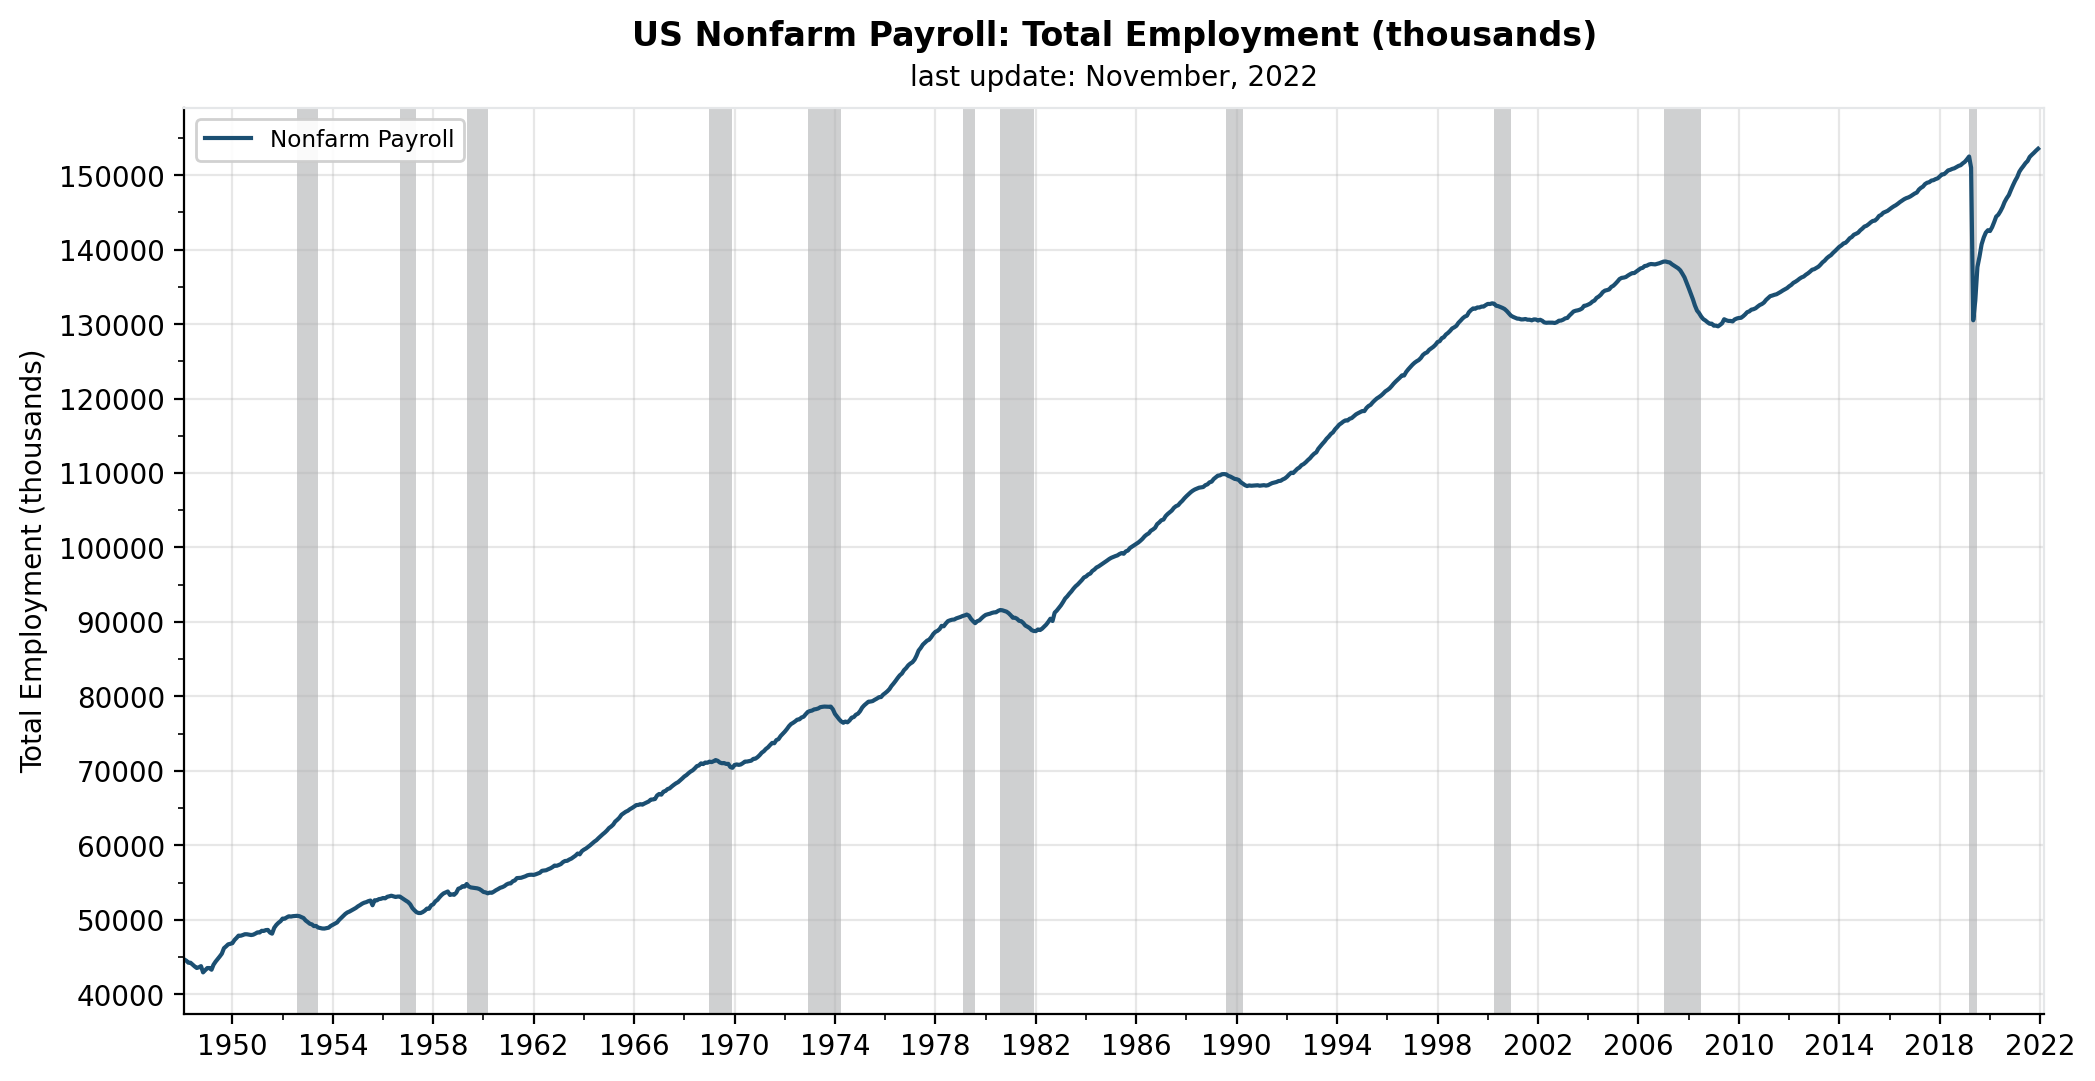

In [9]:
# NonFarm Payroll
data = (
    ces[ces["series_id"]=="CES0000000001"]
    .copy()
    .replace("CES0000000001","Nonfarm Payroll")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Nonfarm Payroll'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1949-01-01",
                  title ='US Nonfarm Payroll: Total Employment (thousands)',
                  ylab='Total Employment (thousands)',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 10000, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

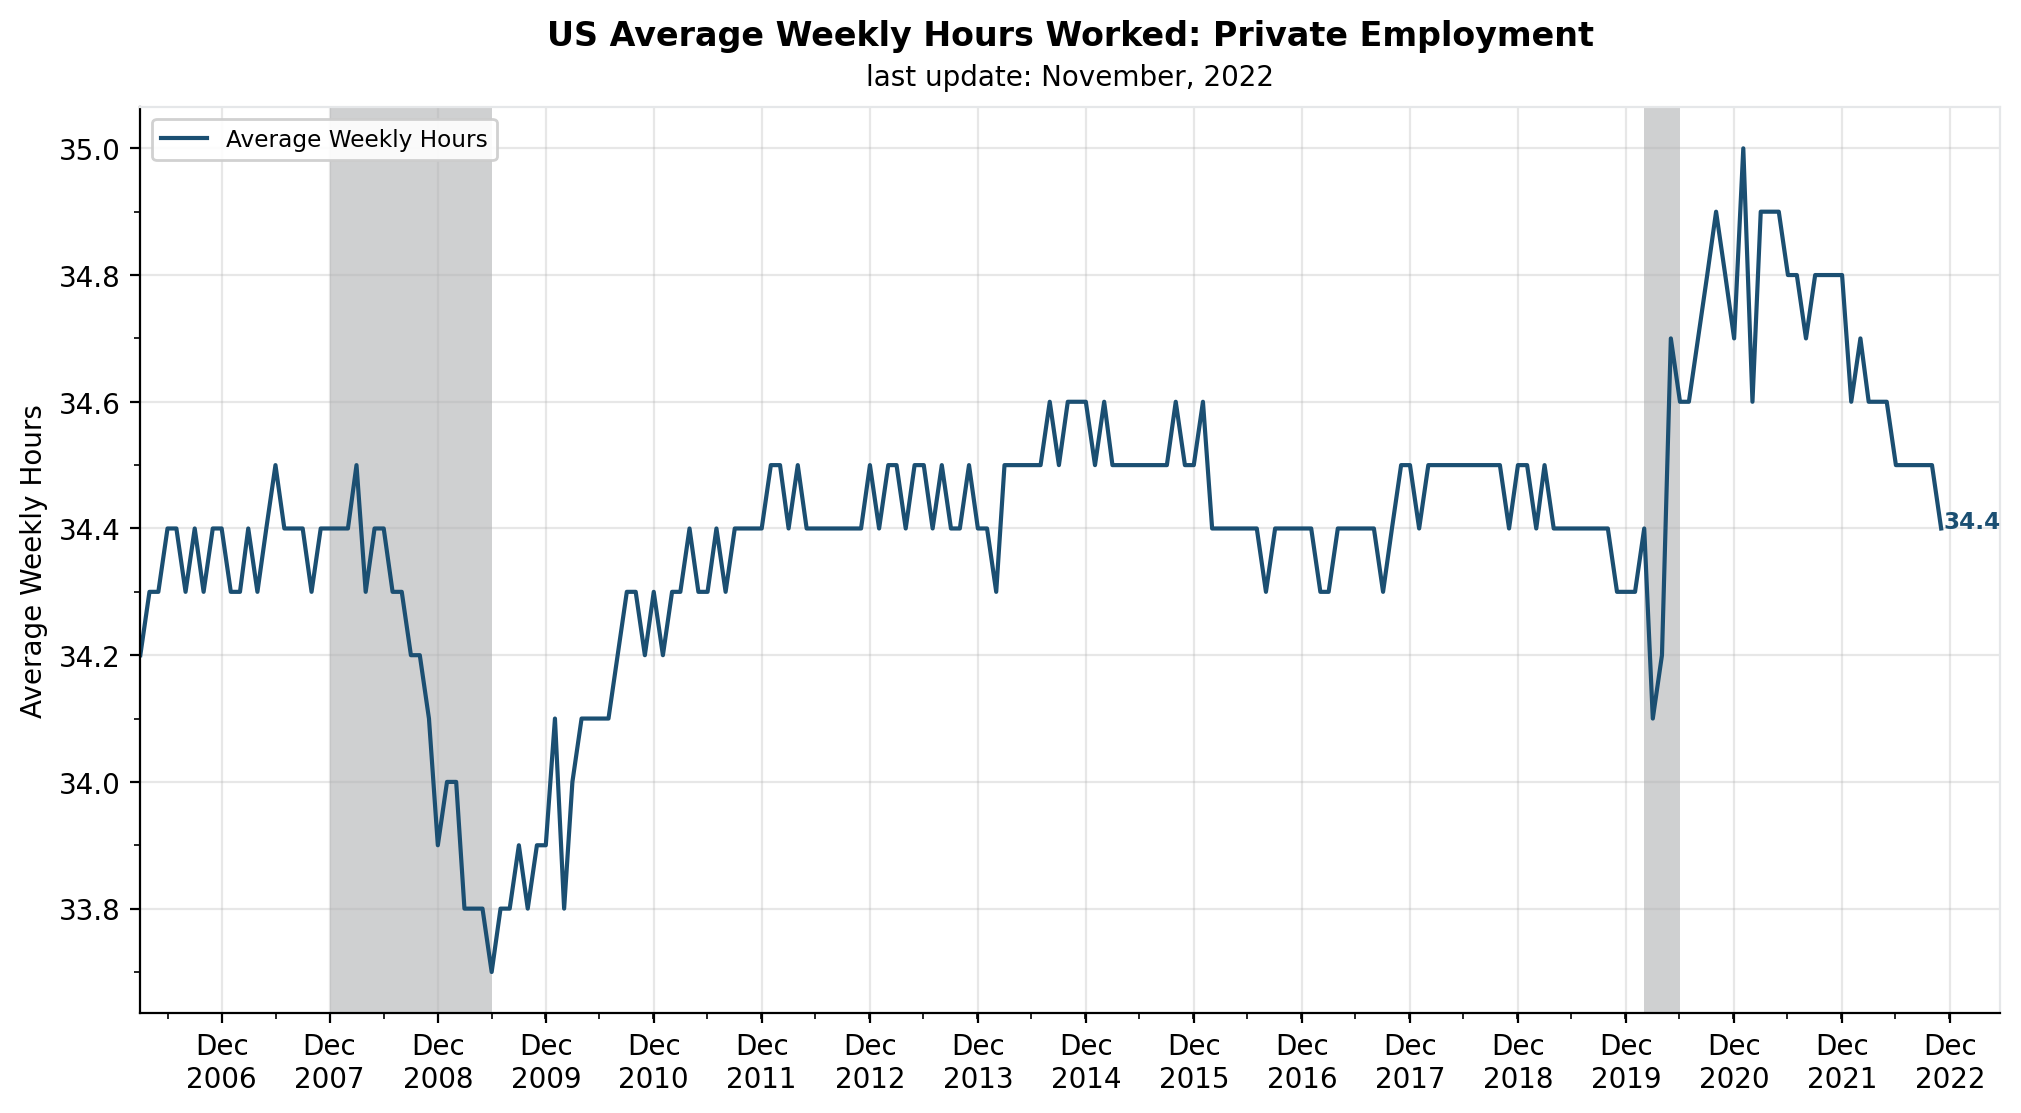

In [18]:
# Average Weekly Hours
data = (
    ces[ces["series_id"]=="CES0500000002"]
    .copy()
    .replace("CES0500000002","Average Weekly Hours")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Average Weekly Hours'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2006-03-01",
                  title ='US Average Weekly Hours Worked: Private Employment',
                  ylab='Average Weekly Hours',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.2, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=200)

plt.show()

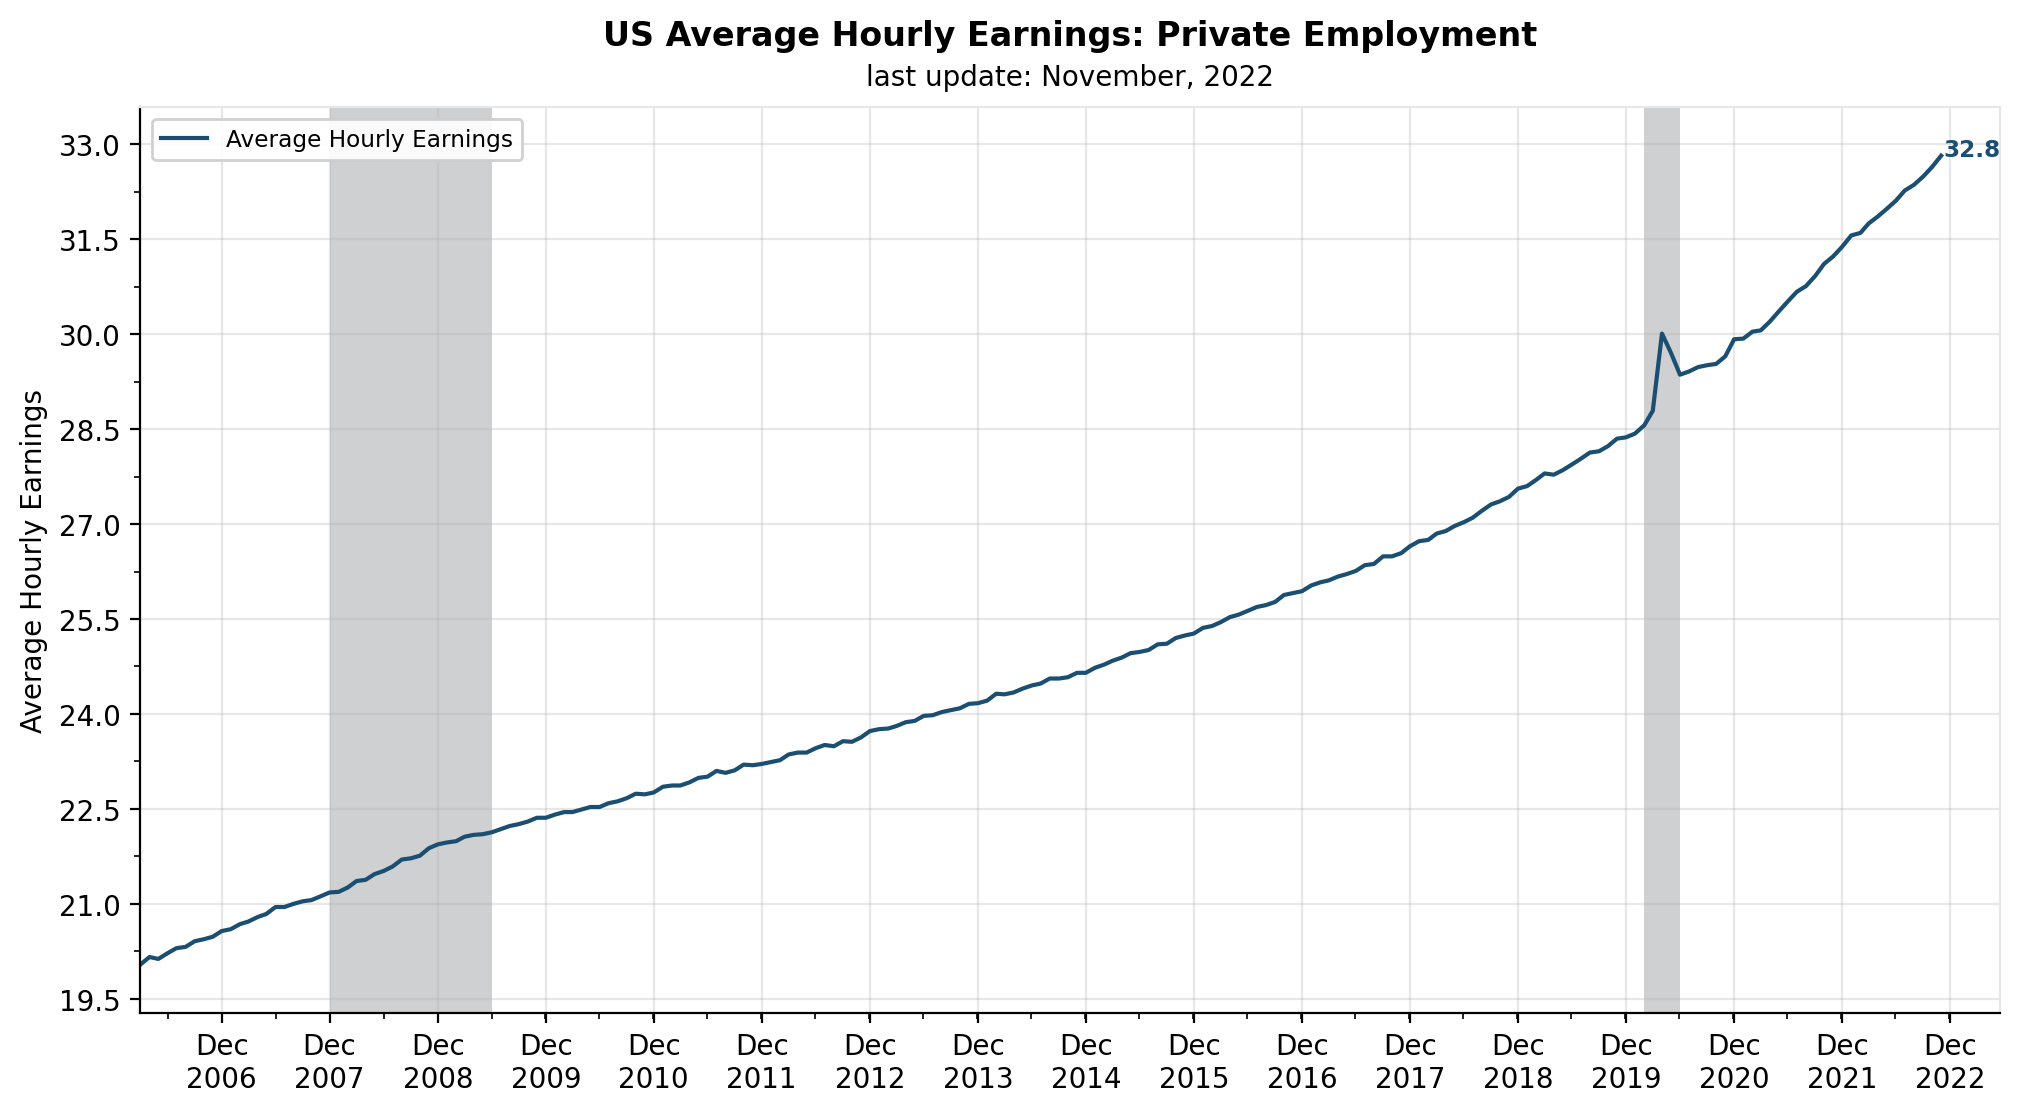

In [31]:
# Average Hourly Earnings
data = (
    ces[ces["series_id"]=="CES0500000003"]
    .copy()
    .replace("CES0500000003","Average Hourly Earnings")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Average Hourly Earnings'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2006-03-01",
                  title ='US Average Hourly Earnings: Private Employment',
                  ylab='Average Hourly Earnings',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.06,
                  y_major_loc = 1.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=200)

plt.show()

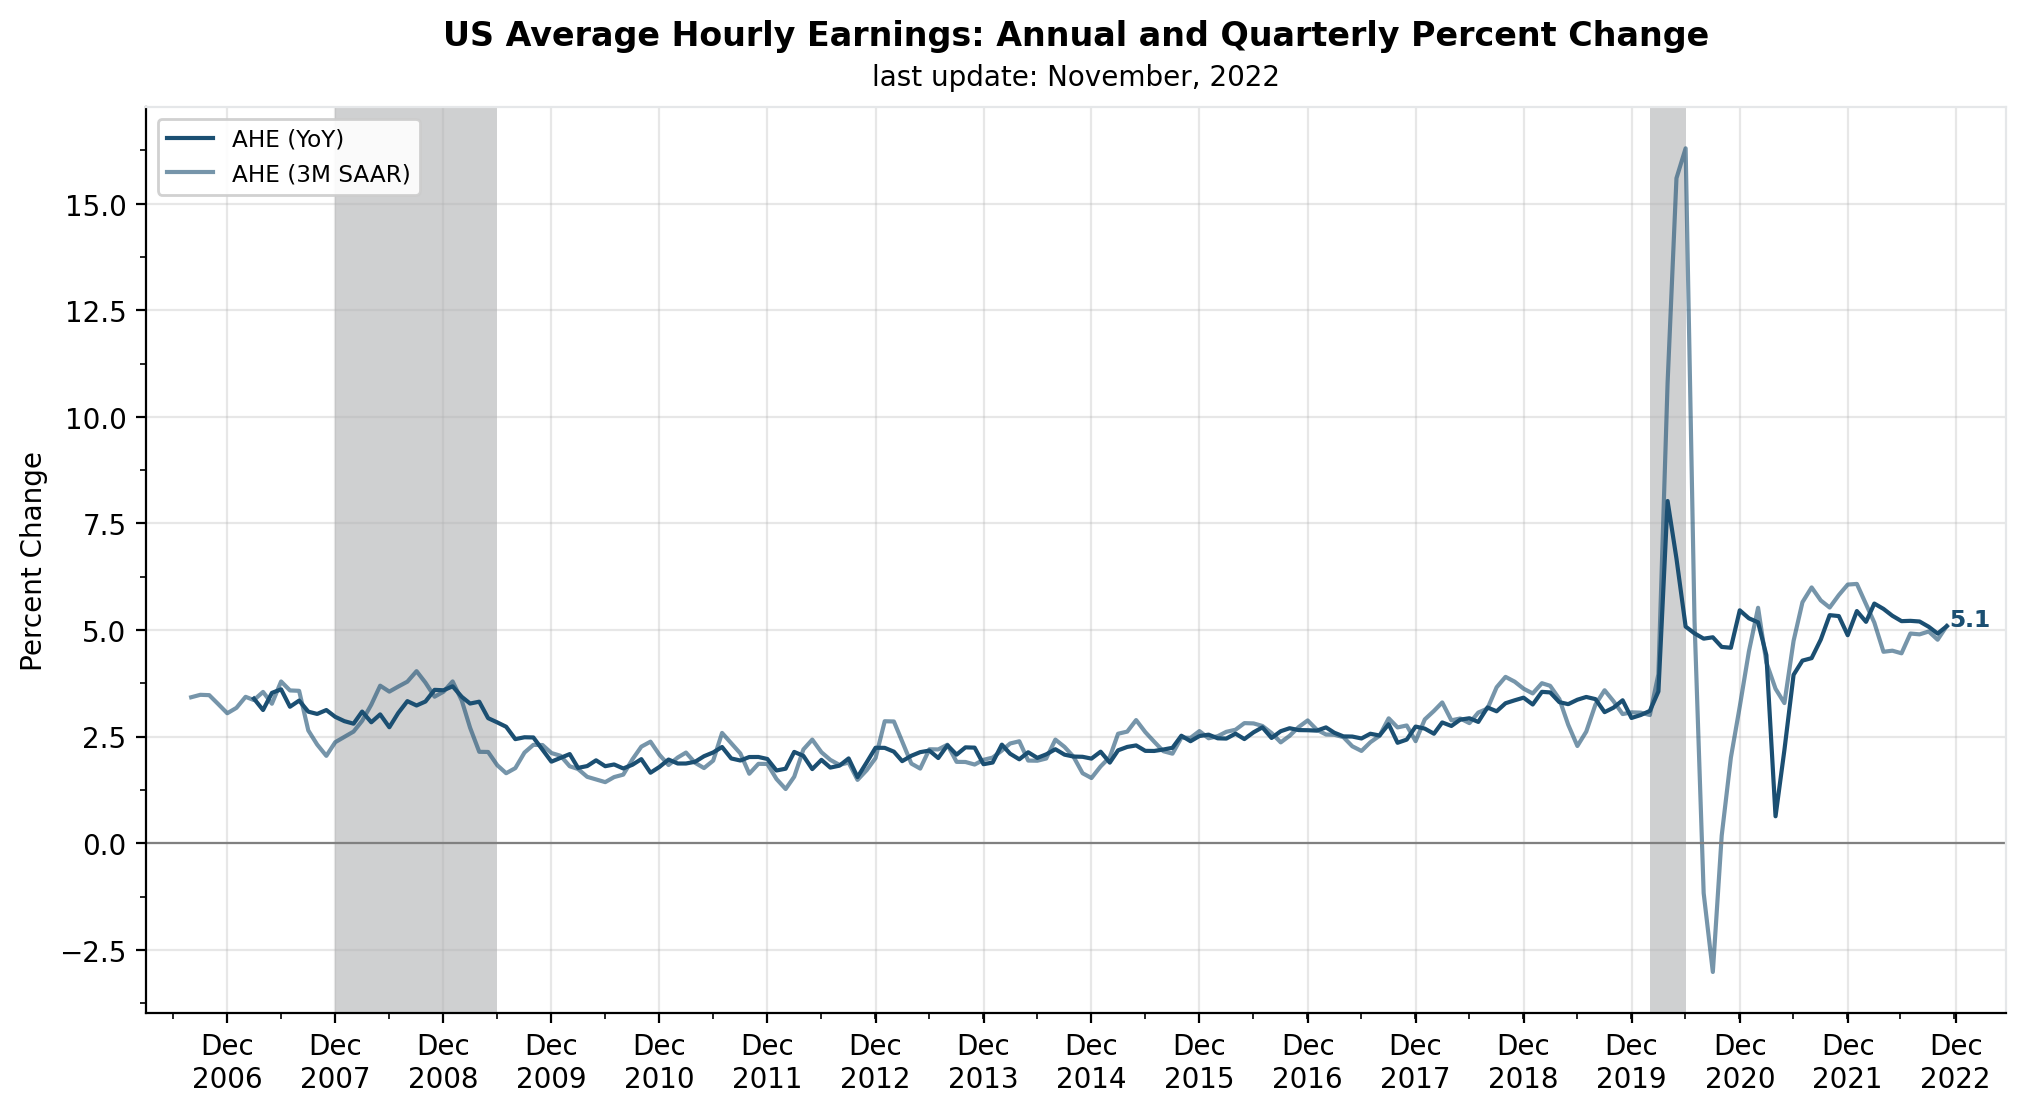

In [34]:
ahe_yoy = compute_change(data, 12).replace("Average Hourly Earnings","AHE (YoY)")
ahe_saar3 = saar(data, 3).replace("Average Hourly Earnings","AHE (3M SAAR)")
ahe = pd.concat([ahe_yoy,ahe_saar3])

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['AHE (YoY)','AHE (3M SAAR)'],
    'hue': [colors[0],colors[0]],
    'alpha':[1, 0.6],
    'annotation':[True, True]})

# running function
fig, ax = ts_plot(df = ahe[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2006-03-01",
                  title ='US Average Hourly Earnings: Annual and Quarterly Percent Change',
                  ylab='Percent Change',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = True,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=200)

plt.show()

## Atlanta Fed Wage Tracker

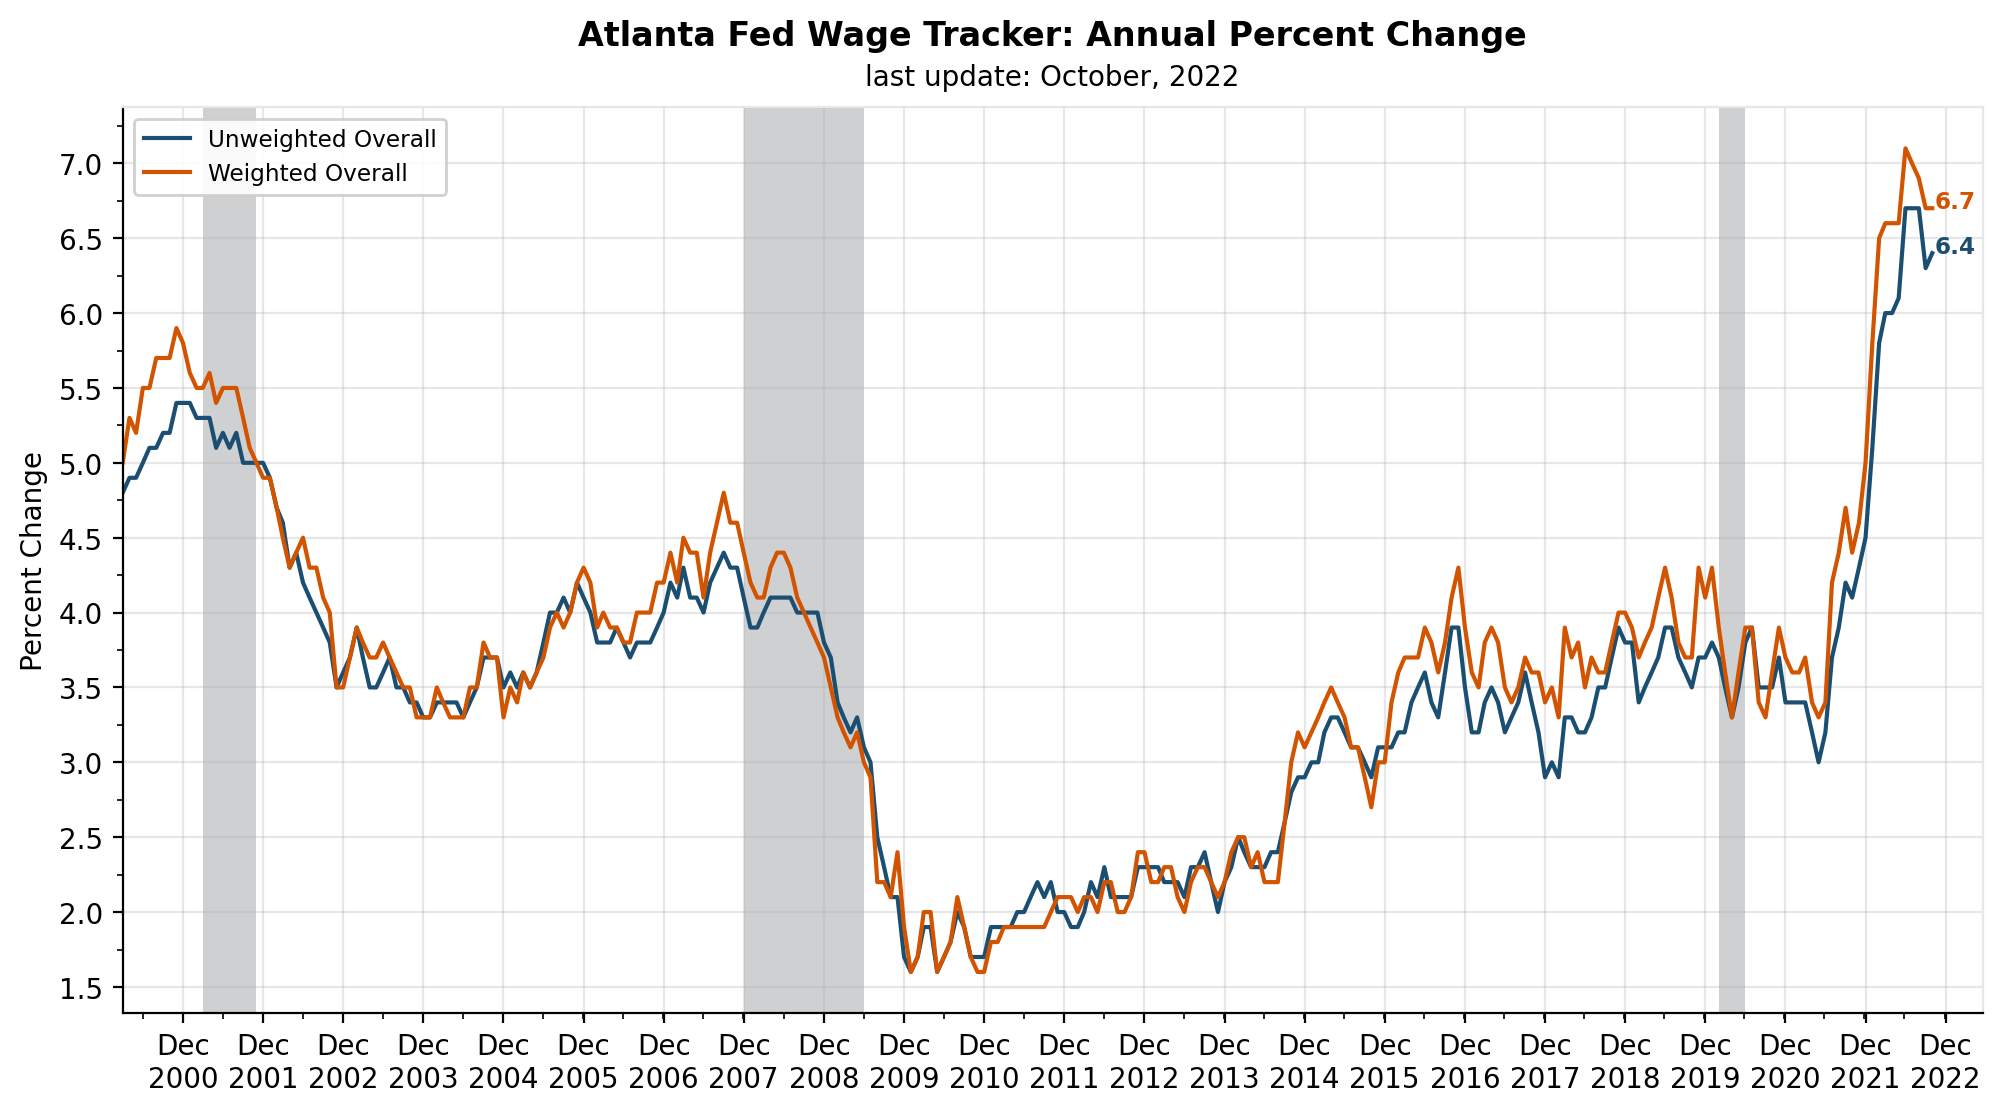

In [45]:
# Atlanta Fed Wage Tracker
data = (
    wage[wage["series_id"].isin(["Unweighted Overall","Weighted Overall"])]
    .copy()
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Unweighted Overall","Weighted Overall"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[True, True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2000-03-01",
                  title ='Atlanta Fed Wage Tracker: Annual Percent Change',
                  ylab='Percent Change',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=230)

plt.show()

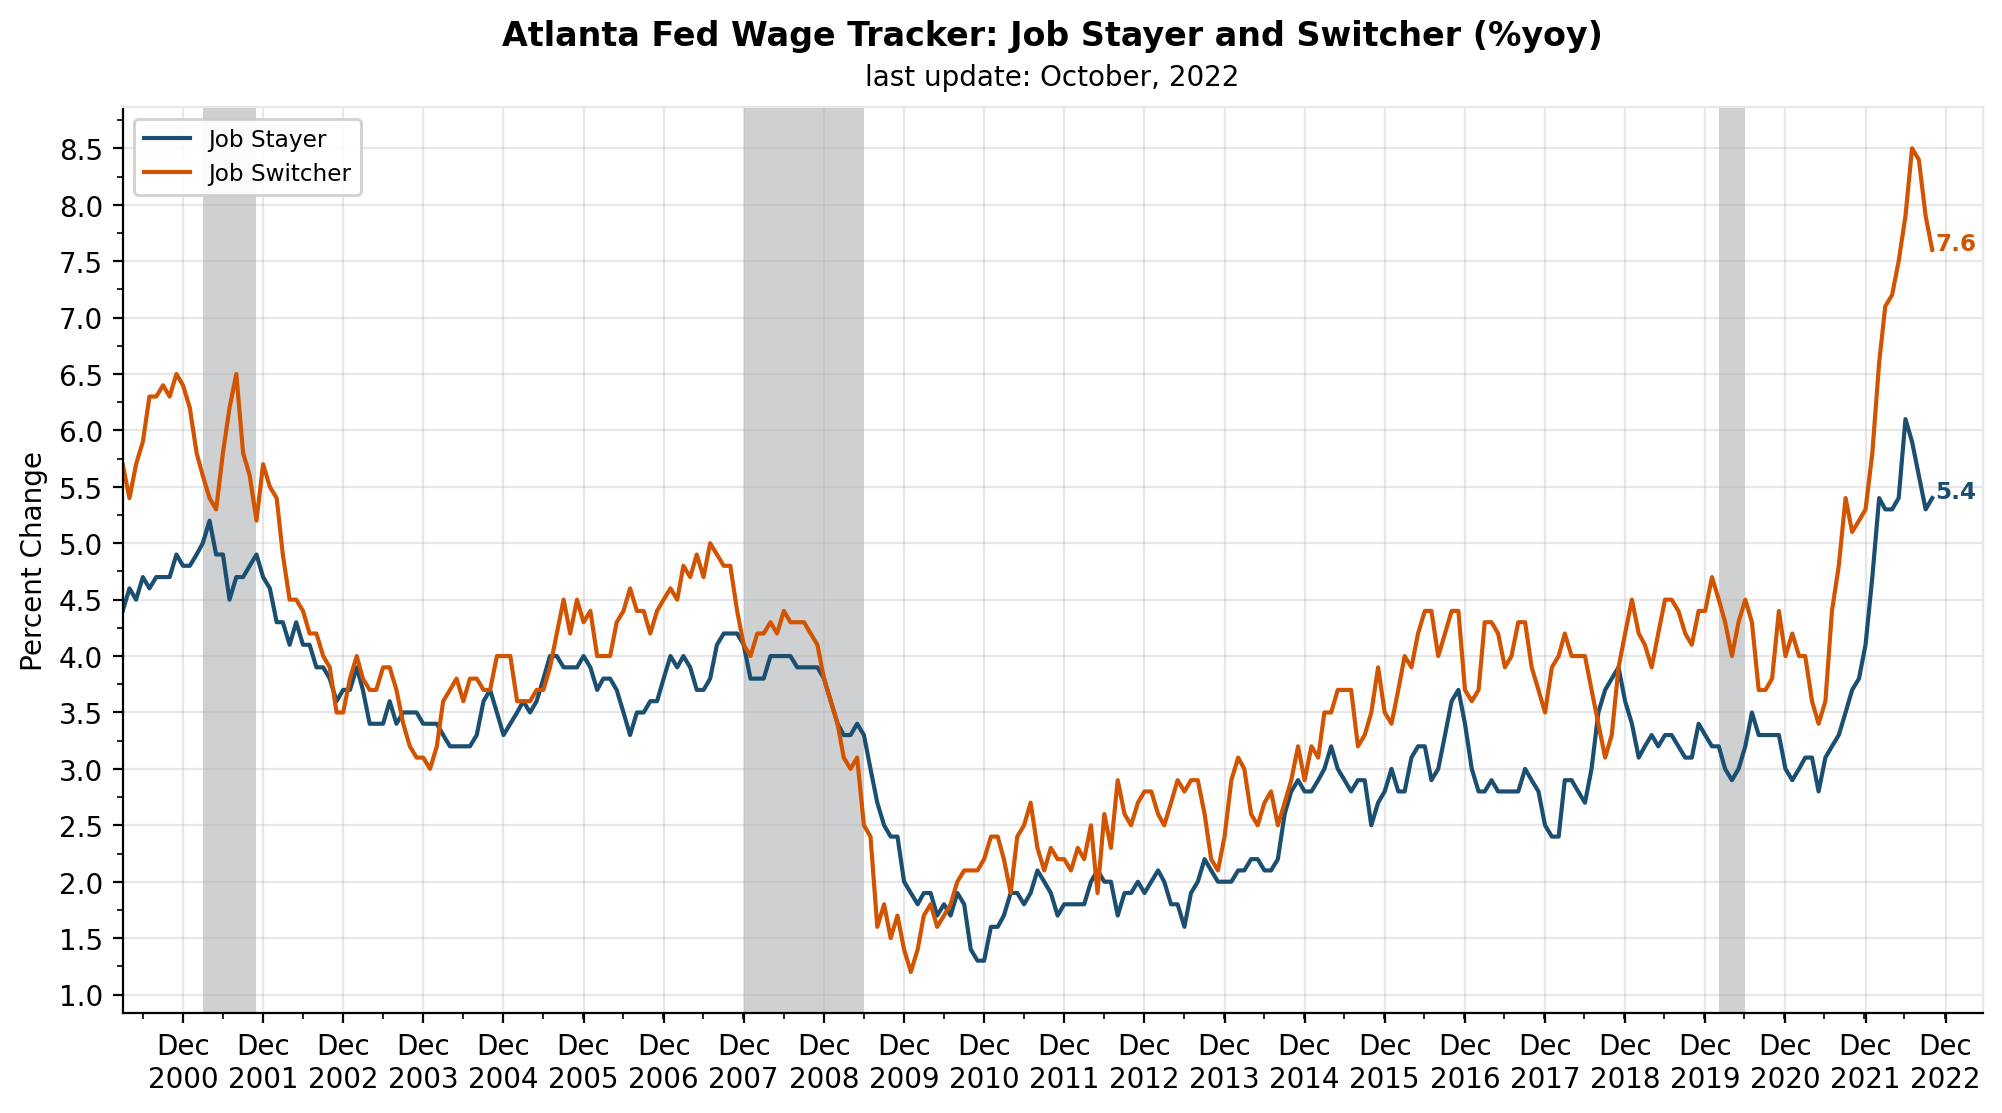

In [47]:
wage.series_id.unique()
#Job Stayer
#Job Switcher

data = (
    wage[wage["series_id"].isin(["Job Stayer","Job Switcher"])]
    .copy()
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ["Job Stayer","Job Switcher"],
    'hue': [colors[0],colors[1]],
    'alpha':[1,1],
    'annotation':[True, True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2000-03-01",
                  title ='Atlanta Fed Wage Tracker: Job Stayer and Switcher (%yoy)',
                  ylab='Percent Change',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.5, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=230)

plt.show()


## Current Population Survey

In [48]:
#cps_dict.columns
cps_dict.lfst_text.unique()
cps_dict[(cps_dict["lfst_text"]=="Unemployed") &
         (cps_dict["sexs_text"]=="Both Sexes")].head()

# Unemployment: LNS13000000
# Unemployment rate: LNS14000000
# Civilian labor force participation rate: LNS11300000

,series_id,series_title,seasonal,lfst_text,absn_text,activity_text,ages_text,cert_text,class_text,duration_text,...,rnlf_text,rwns_text,seek_text,sexs_text,tdat_text,vets_text,wkst_text,born_text,chld_text,disa_text
360,LNS13000000,(Seas) Unemployment Level,S,Unemployed,None,None,16 years and over,None,None,None,...,None,None,None,Both Sexes,Number in thousands,None,None,None,None,None
363,LNS13000003,(Seas) Unemployment Level - White,S,Unemployed,None,None,16 years and over,None,None,None,...,None,None,None,Both Sexes,Number in thousands,None,None,None,None,None
366,LNS13000006,(Seas) Unemployment Level - Black or African A...,S,Unemployed,None,None,16 years and over,None,None,None,...,None,None,None,Both Sexes,Number in thousands,None,None,None,None,None
369,LNS13000009,(Seas) Unemployment Level - Hispanic or Latino,S,Unemployed,None,None,16 years and over,None,None,None,...,None,None,None,Both Sexes,Number in thousands,None,None,None,None,None
370,LNS13000012,(Seas) Unemployment Level - 16-19 yrs.,S,Unemployed,None,None,16 to 19 years,None,None,None,...,None,None,None,Both Sexes,Number in thousands,None,None,None,None,None


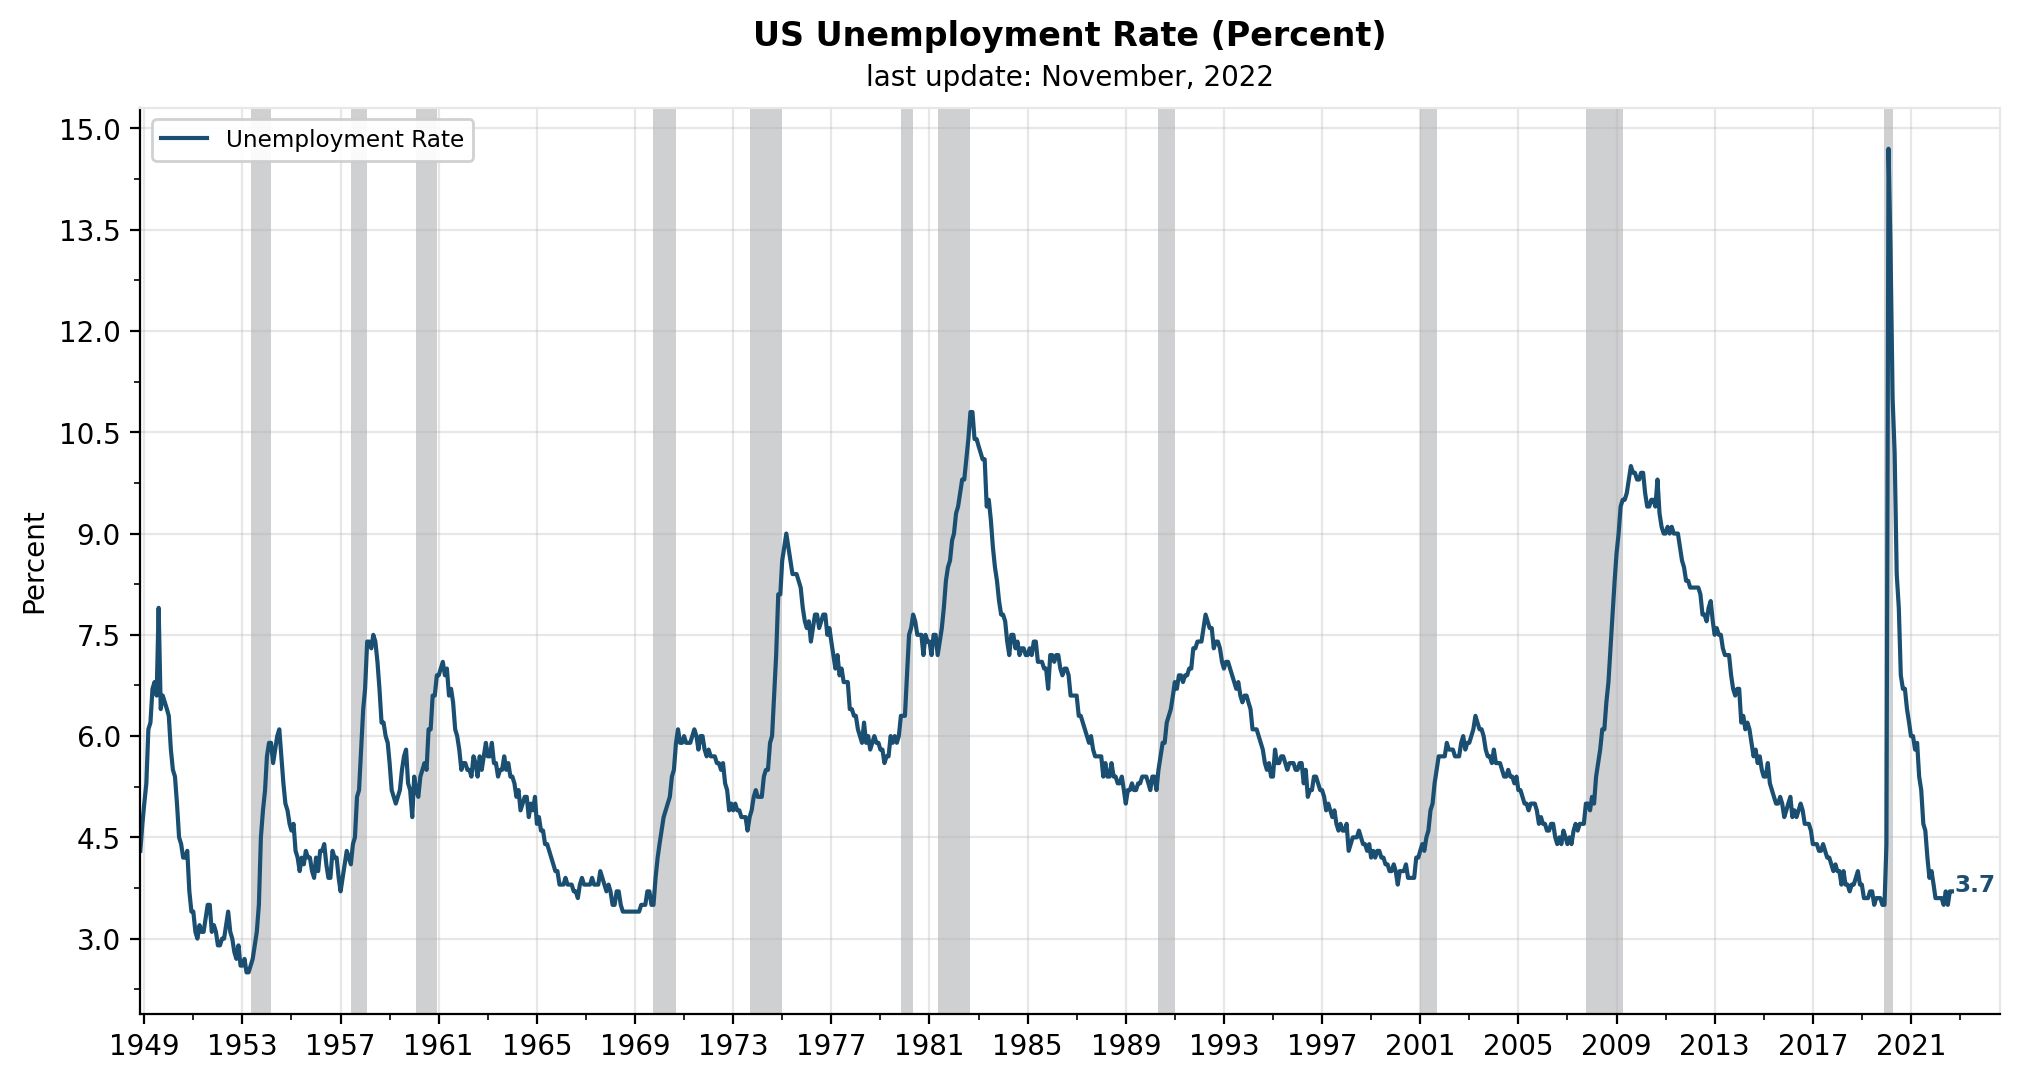

In [52]:
# Unemployment Rate SA
data = (
    cps[cps["series_id"]=="LNS14000000"]
    .copy()
    .replace("LNS14000000","Unemployment Rate")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Unemployment Rate'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1949-01-01",
                  title ='US Unemployment Rate (Percent)',
                  ylab='Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1.5, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=720)

plt.show()

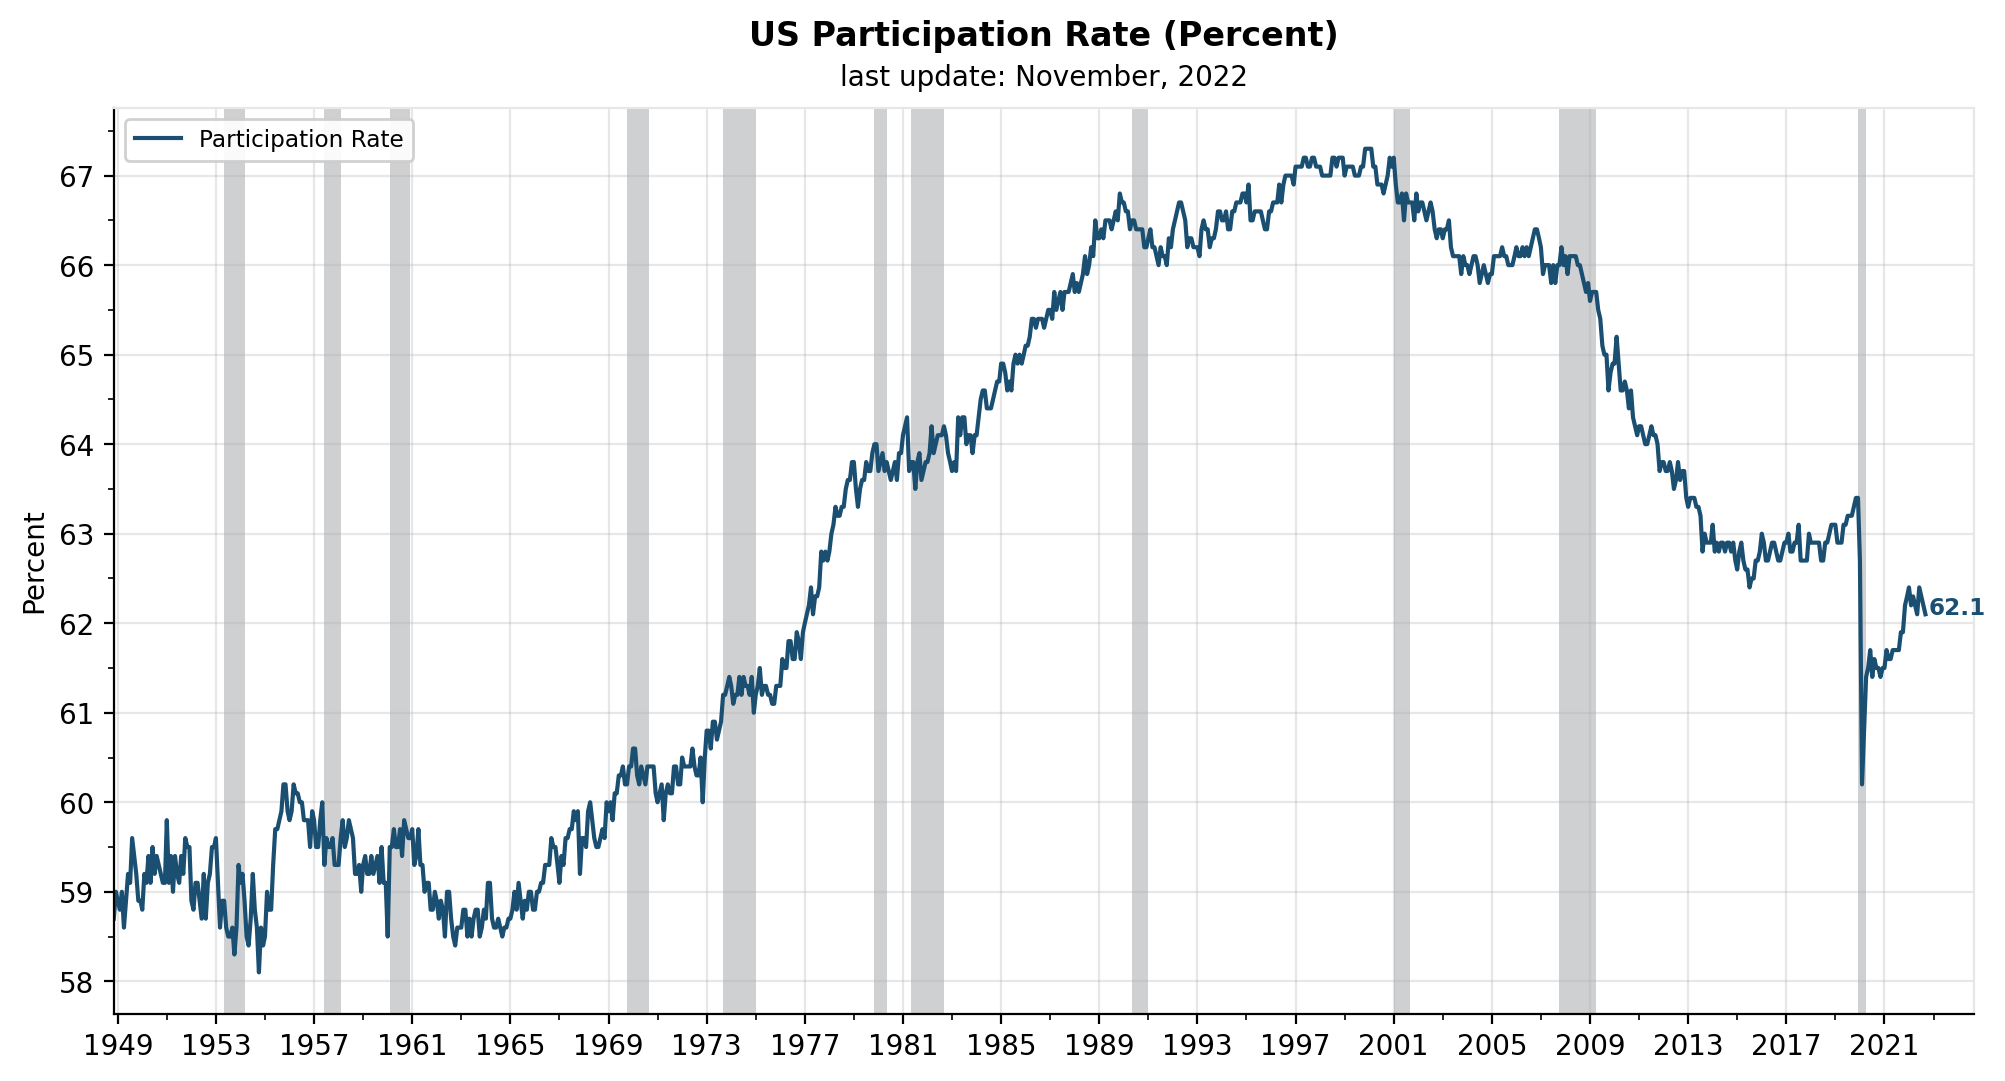

In [54]:
# Participation Rate
data = (
    cps[cps["series_id"]=="LNS11300000"]
    .copy()
    .replace("LNS11300000","Participation Rate")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Participation Rate'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1949-01-01",
                  title ='US Participation Rate (Percent)',
                  ylab='Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=720)

plt.show()

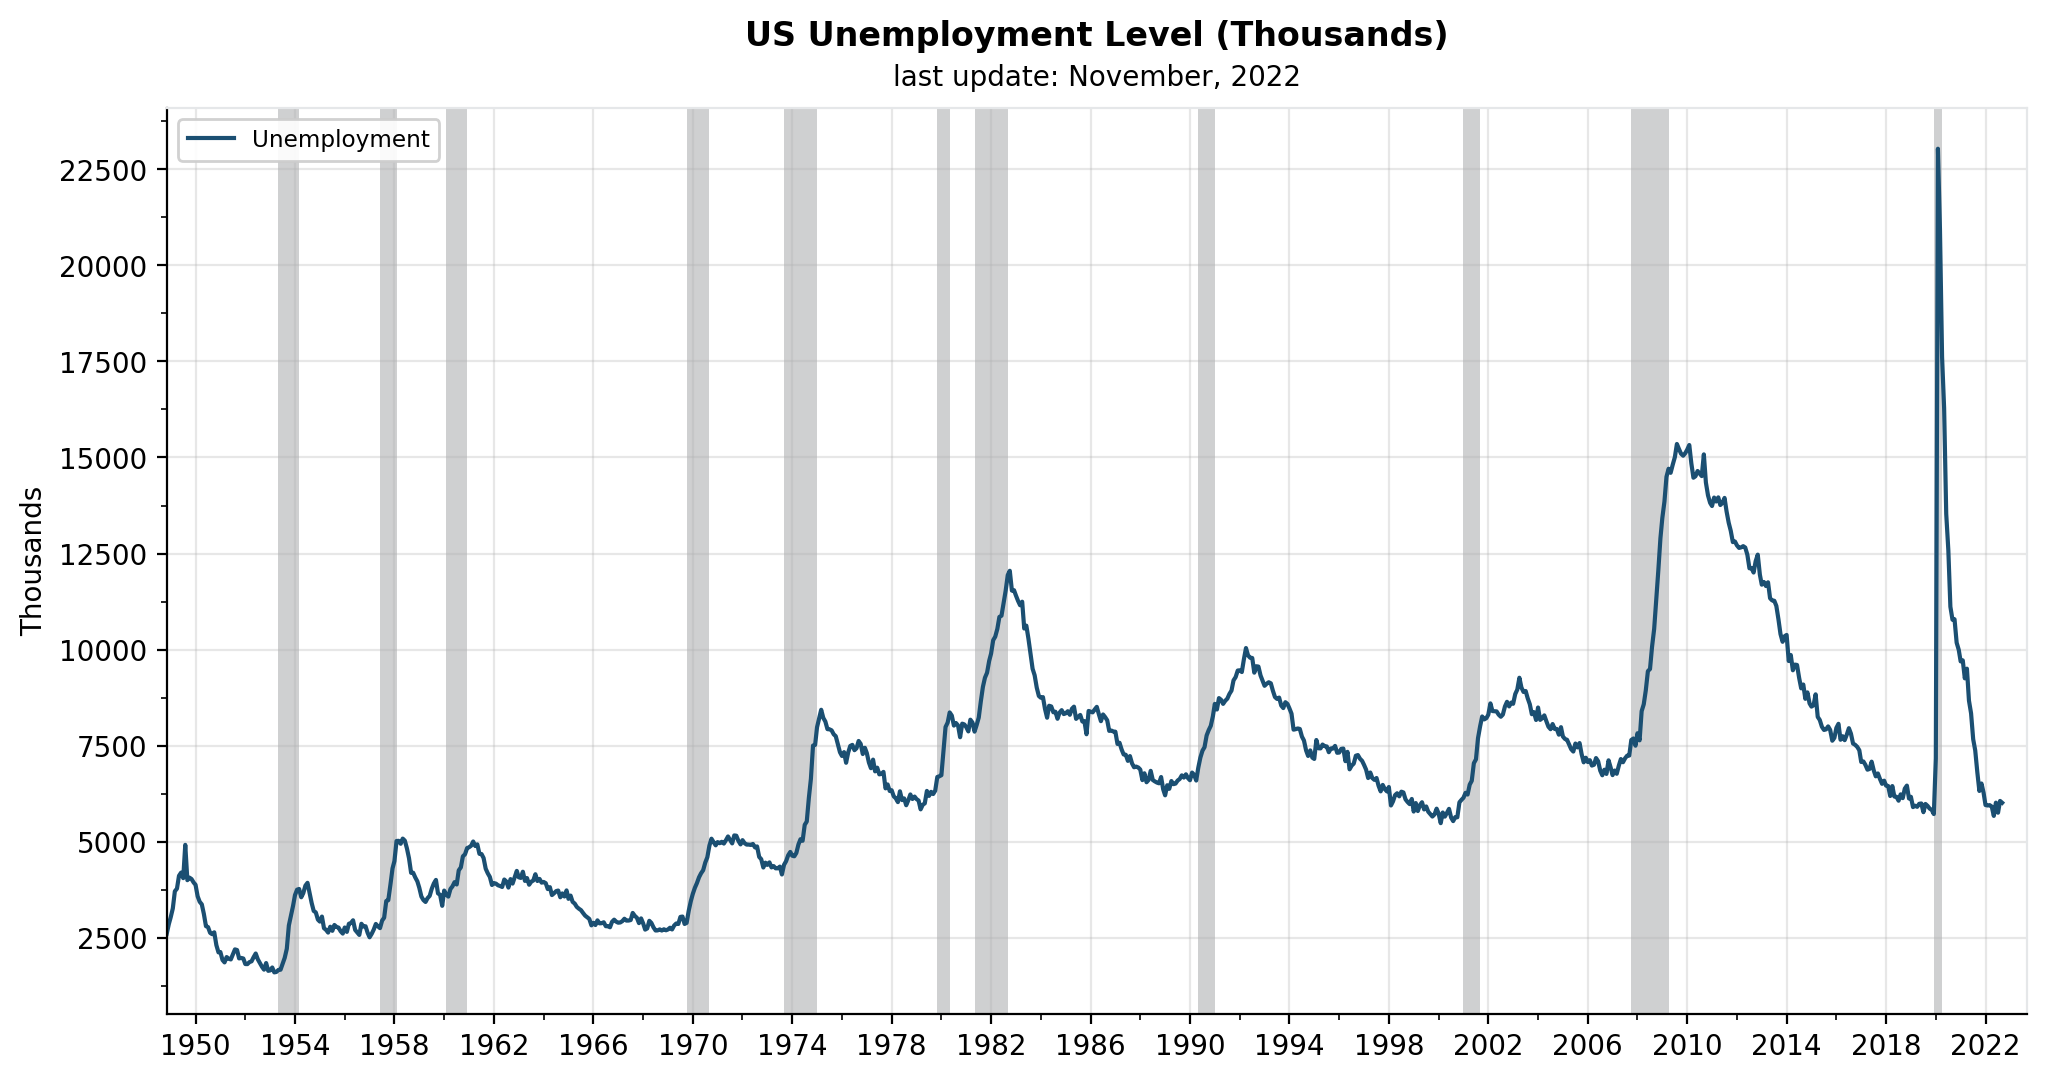

In [55]:
#Unemployment: LNS13000000
# Unemployment Rate SA
data = (
    cps[cps["series_id"]=="LNS13000000"]
    .copy()
    .replace("LNS13000000","Unemployment")
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Unemployment'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1949-01-01",
                  title ='US Unemployment Level (Thousands)',
                  ylab='Thousands',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2500, y_minor_loc = 2,
                  x_major_loc = 48, x_minor_loc = 2, x_format = "%Y", n=360)

plt.show()

## Jobless Claims

In [56]:
# Weekly Initial Claims:
claims.tail()

,series_id,date,value,series_name,unit,seasonal
2910,CCSA,2022-10-15,1438000.0,US Contined Claims,Number,S
2911,CCSA,2022-10-22,1487000.0,US Contined Claims,Number,S
2912,CCSA,2022-10-29,1498000.0,US Contined Claims,Number,S
2913,CCSA,2022-11-05,1503000.0,US Contined Claims,Number,S
2914,CCSA,2022-11-12,1551000.0,US Contined Claims,Number,S


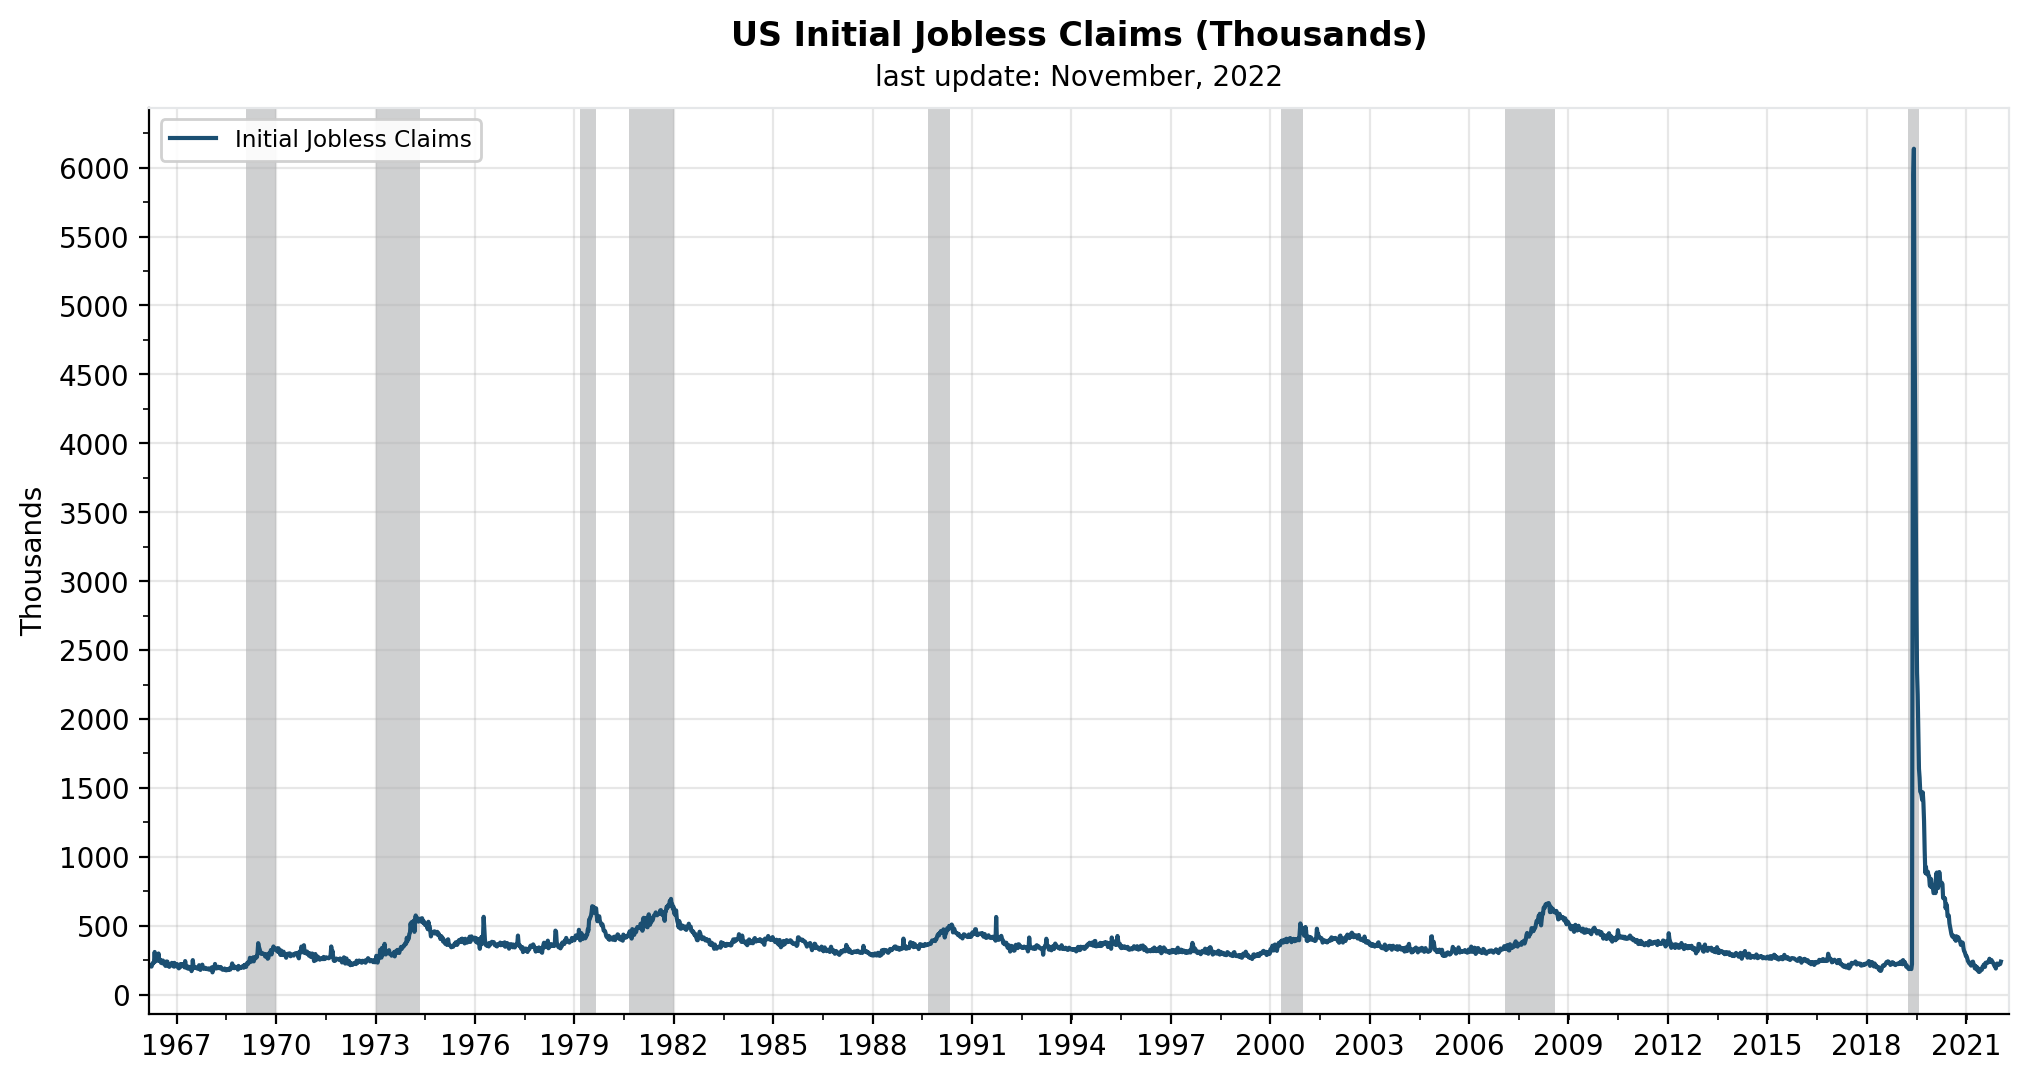

In [57]:
# Initial Claims
data = (
    claims[claims["series_id"]=="ICSA"]
    .copy()
    .replace("ICSA","Initial Jobless Claims")[["series_id","date","value"]]
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Initial Jobless Claims'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1967-01-01",
                  title ='US Initial Jobless Claims (Thousands)',
                  ylab='Thousands',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 500, y_minor_loc = 2,
                  x_major_loc = 36, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

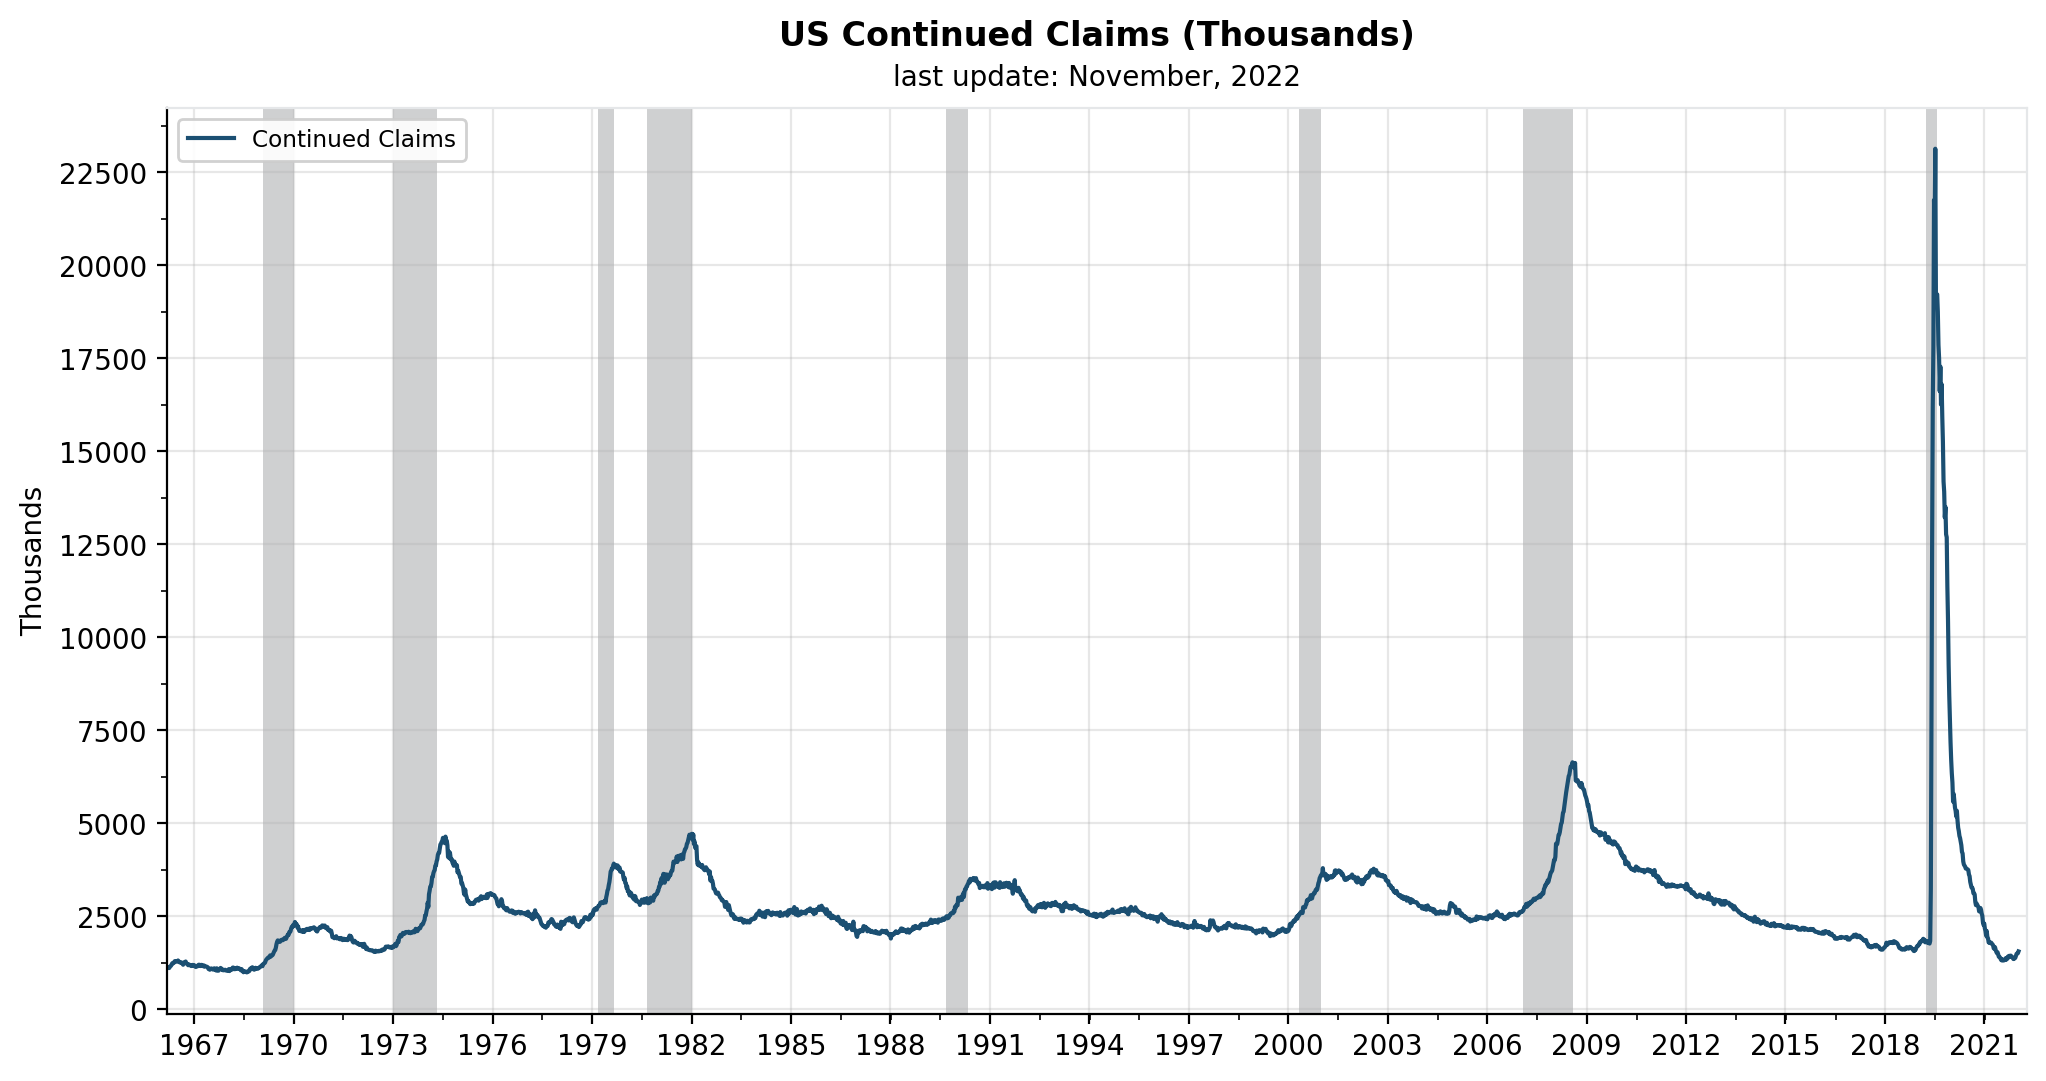

In [58]:
# Continued Claims
data = (
    claims[claims["series_id"]=="CCSA"]
    .copy()
    .replace("CCSA","Continued Claims")[["series_id","date","value"]]
)

data["value"] = data["value"]/1000

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Continued Claims'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "1967-01-01",
                  title ='US Continued Claims (Thousands)',
                  ylab='Thousands',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 2500, y_minor_loc = 2,
                  x_major_loc = 36, x_minor_loc = 2, x_format = "%Y", n=90)

plt.show()

In [59]:
# continued claims+ extended benefits
c_claims = (
    claims[claims["series_id"]=="CCSA"]
    .copy()
    .rename(columns={"value":"Continued Claims"})[["date","Continued Claims"]]
)

c_claims = pd.merge(c_claims, eb, how="left")
c_claims = c_claims[c_claims["date"]>="2020"]

c_claims["Continued Claims"] = c_claims["Continued Claims"]/1000
c_claims["Extended Benefits"] = c_claims["Extended Benefits"]/1000
c_claims["PUA"] = c_claims["PUA"]/1000
c_claims["PEUC"] = c_claims["PEUC"]/1000

c_claims.head()

,date,Continued Claims,Extended Benefits,PUA,PEUC
2765,2020-01-04,1876.0,0.0,0.0,0.0
2766,2020-01-11,1835.0,0.0,0.0,0.0
2767,2020-01-18,1797.0,0.0,0.0,0.0
2768,2020-01-25,1839.0,0.0,0.0,0.0
2769,2020-02-01,1799.0,0.0,0.0,0.0


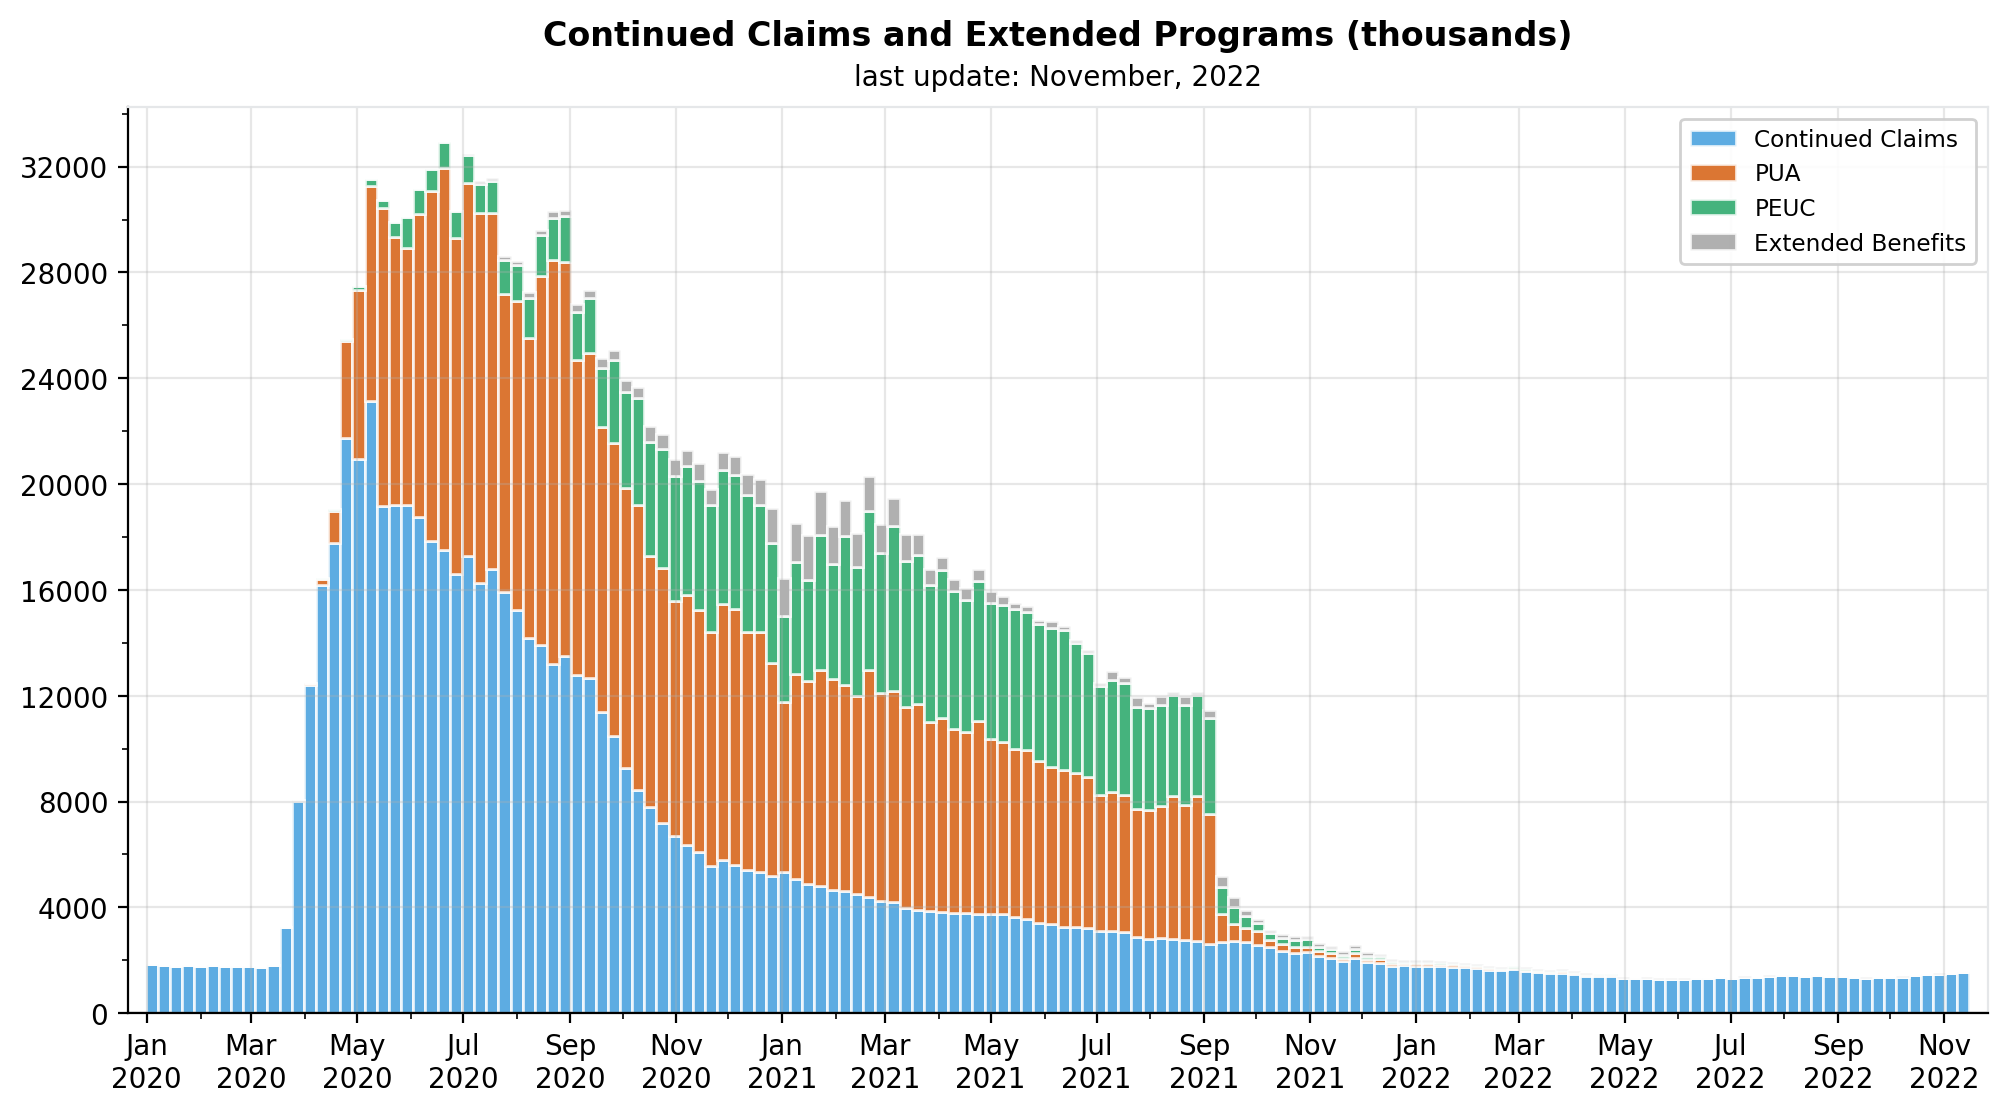

In [60]:
# chart:
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(12,6))

# positive values
ax.bar(c_claims["date"], c_claims["Continued Claims"],
       width = 7, label="Continued Claims", color= colors[4], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["PUA"], width = 7,
       bottom = c_claims["Continued Claims"], label="PUA", color= colors[1], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["PEUC"], width = 7,
       bottom = c_claims["Continued Claims"]+c_claims["PUA"], label="PEUC", color= colors[2], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.bar(c_claims["date"], c_claims["Extended Benefits"], width = 7,
       bottom = c_claims["Continued Claims"]+c_claims["PUA"]+c_claims["PEUC"], label="Extended Benefits",
       color= colors[5], alpha=0.8,
       edgecolor = 'white', linewidth = 1)

ax.legend(['Continued Claims', 'PUA','PEUC', 'Extended Benefits'], 
    loc='upper right', frameon=True, framealpha=0.9, fontsize='small')

ax.axhline(y=0, color='gray', lw=0.8, label = "_line")

ax.margins(x=0.01, y=0.04)

# date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

year_month_formatter = mdates.DateFormatter("%b\n%Y")
ax.xaxis.set_major_formatter(year_month_formatter)

# y axis
ax.yaxis.set_major_locator(MultipleLocator(4000))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylabel(None)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.spines['top'].set_edgecolor(colors[107])
ax.spines['right'].set_edgecolor(colors[107])

ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.3)

ax.set_title('Continued Claims and Extended Programs (thousands)', y=1.05, loc="center",
            fontweight="bold")

# subtitle...
last = c_claims.loc[c_claims['date']==max(c_claims['date']),:]

ax.xaxis.set_label_position('top')
text = last["date"].dt.strftime("%B, %Y").values[0]

ax.set_xlabel(f"last update: {text}",
              labelpad = 8, loc="center")

plt.show()

## Jolts

In [61]:
jolts_dict.columns
#industry_text
#ratelevel_text
#dataelement_text
#jolts_dict.dataelement_text.unique() # Job openings
#jolts_dict.ratelevel_text.unique() #rate
#jolts_dict.industry_text.unique() #Total nonfarm
jolts_dict[jolts_dict["series_id"]=="JTS000000000000000JOL"]
jolts[jolts["series_id"]=="JTS000000000000000JOL"].head()

,series_id,date,value
524,JTS000000000000000JOL,2000-12-01,5088.0
525,JTS000000000000000JOL,2001-01-01,5234.0
526,JTS000000000000000JOL,2001-02-01,5097.0
527,JTS000000000000000JOL,2001-03-01,4762.0
528,JTS000000000000000JOL,2001-04-01,4615.0


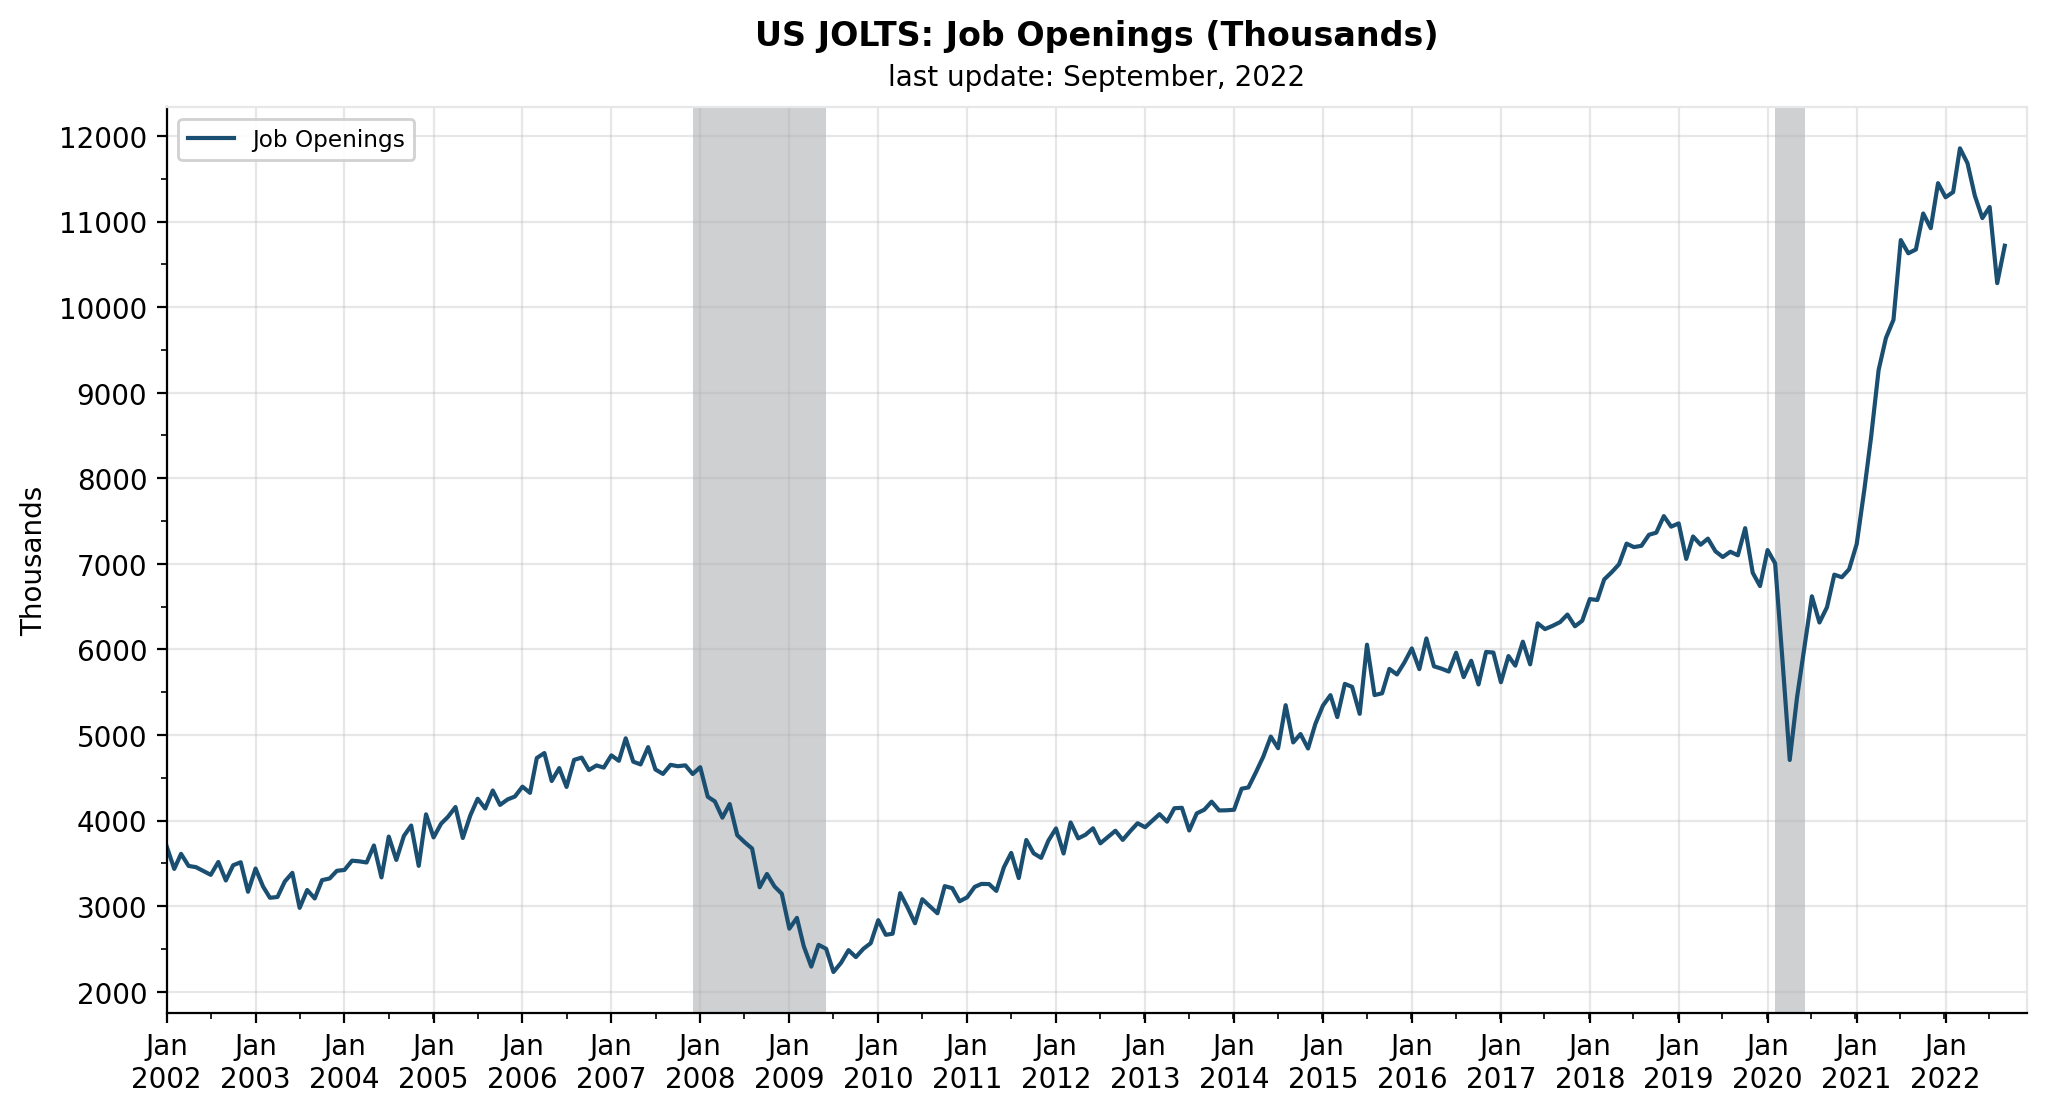

In [63]:
# Continued Claims
data = (
    jolts[jolts["series_id"]=="JTS000000000000000JOL"]
    .copy()
    .replace("JTS000000000000000JOL","Job Openings")[["series_id","date","value"]]
)

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Job Openings'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[False]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2002-01-01",
                  title ='US JOLTS: Job Openings (Thousands)',
                  ylab='Thousands',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 1000, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=90)

plt.show()

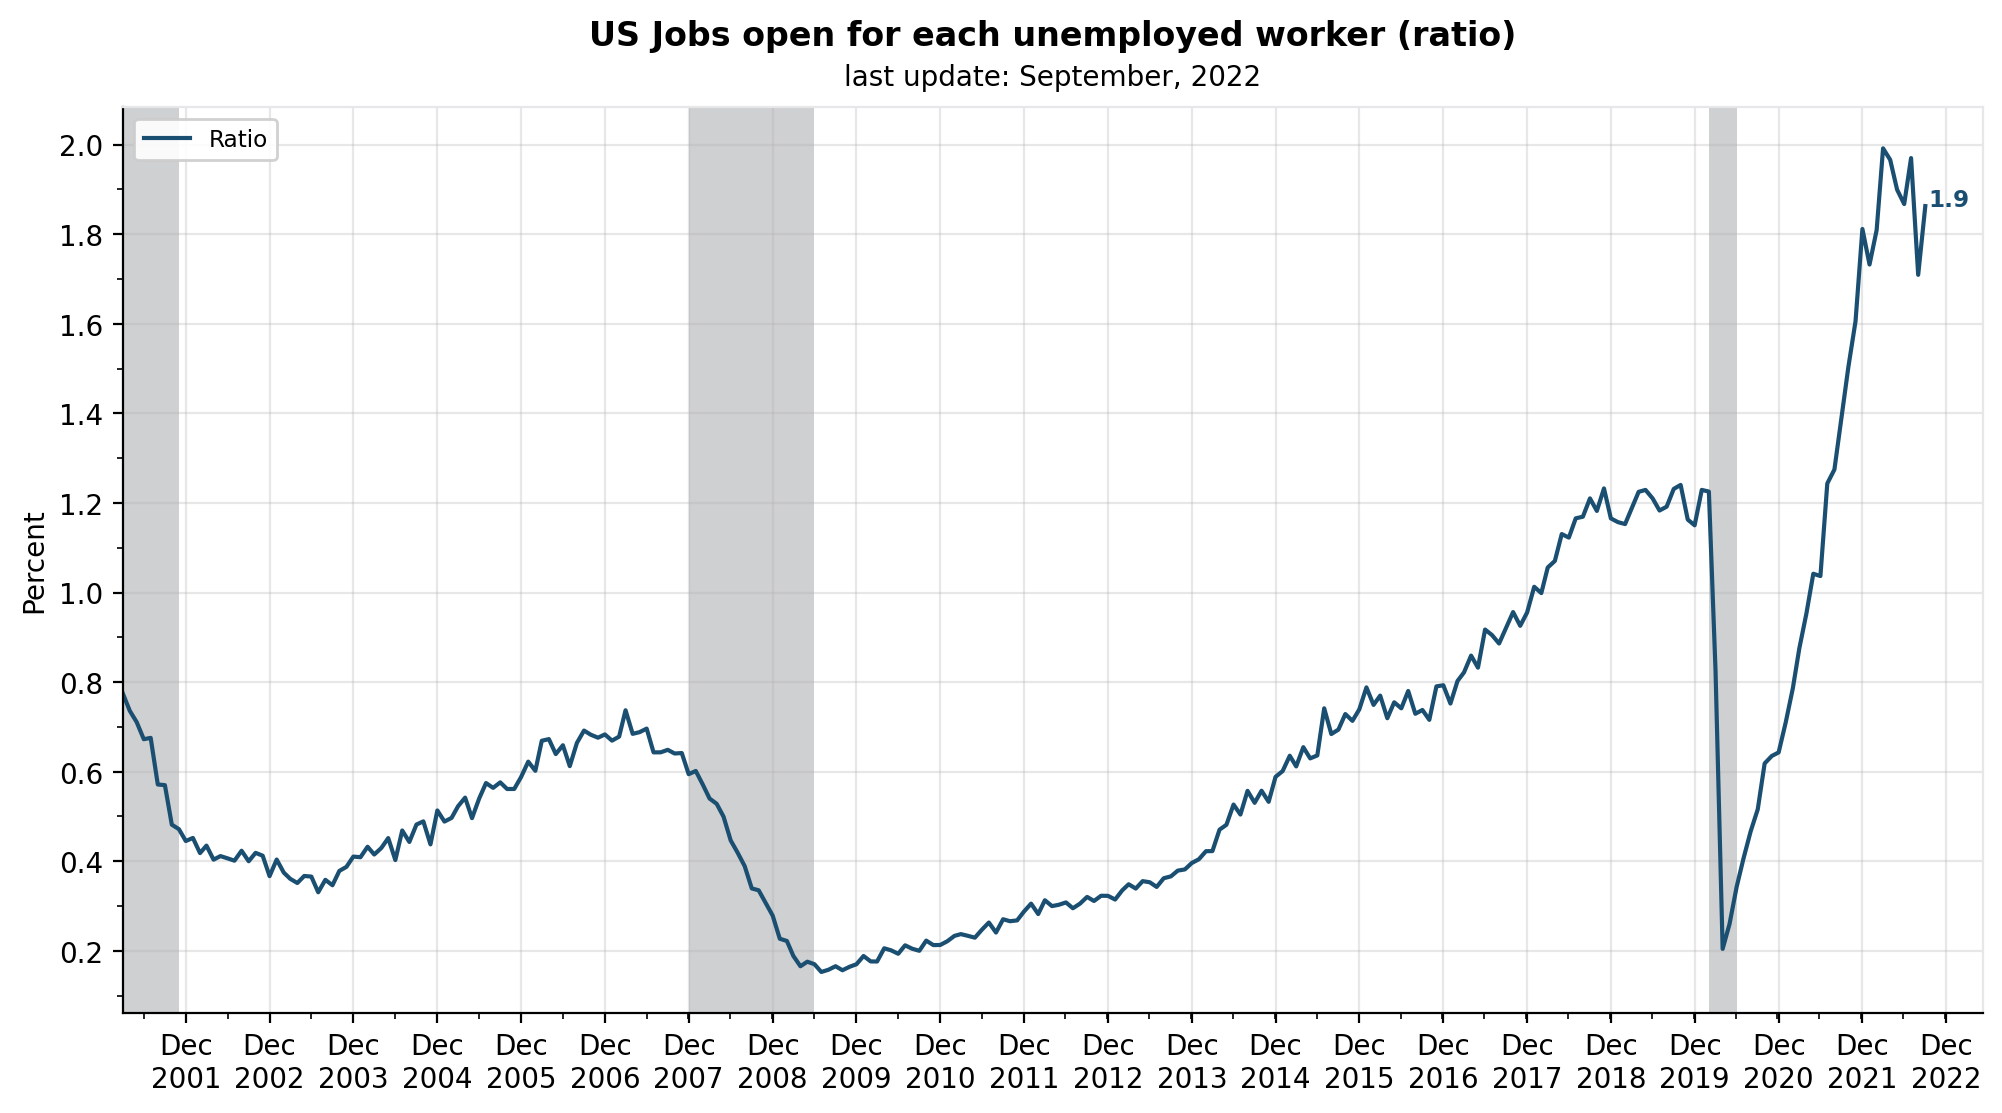

In [85]:
unemp = (
    cps[cps["series_id"]=="LNS13000000"]
    .copy()
    .rename(columns = {"value":"Unemployment"})[["date","Unemployment"]]
)

openings = (
    jolts[jolts["series_id"]=="JTS000000000000000JOL"]
    .copy()
    .rename(columns = {"value":"Job Openings"})[["date","Job Openings"]]
)

data = pd.merge(openings,unemp, how="left")
data["Ratio"] = data["Job Openings"]/data["Unemployment"]
data = data.melt(id_vars="date",var_name="series_id")[["series_id","date","value"]]

# chart:
plt.rcParams['figure.dpi'] = 200 # high quality figure.

# creating the df to map chart configuration:
df_code = pd.DataFrame({
    'series_id': ['Ratio'],
    'hue': [colors[0]],
    'alpha':[1],
    'annotation':[True]})

# running function
fig, ax = ts_plot(df = data[["series_id","date","value"]],
                  df_map = df_code,
                  start_date = "2001-03-01",
                  title ='US Jobs open for each unemployed worker (ratio)',
                  ylab='Percent',
                  fig_size = (12,6), legend_loc = "upper left",
                  plot_recession = True, plot_zero = False,
                  xmargin = 0.00, ymargin = 0.05,
                  y_major_loc = 0.2, y_minor_loc = 2,
                  x_major_loc = 12, x_minor_loc = 2, x_format = "%b\n%Y", n=250)

plt.show()